# Movielens EDA and Modeling
> EDA and modeling on movielens dataset

- toc: true
- badges: true
- comments: true
- categories: [EDA, Movie, Visualization]
- image:

## Setup

In [ ]:
# download dataset
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip && unzip ml-100k.zip

In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest.zip && unzip ml-latest.zip

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
from collections import OrderedDict

import gc
import sys
from os.path import join
from os.path import exists
from functools import reduce
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown

import json
import requests
from IPython.display import HTML

In [ ]:
import sys
sys.path.append("/content/drive/MyDrive")
import mykeys

api_key = mykeys.moviedb_key
headers = {'Accept': 'application/json'}
payload = {'api_key': api_key} 
try:
    response = requests.get(
        "http://api.themoviedb.org/3/configuration",
        params=payload,
        headers=headers,
    )
    response = json.loads(response.text)
    base_url = response['images']['base_url'] + 'w185'
except:
    raise ValueError("Your API key might be invalid.")

## Loading

In [ ]:
# loading ratings data
names = ['user_id', 'item_id', 'rating', 'timestamp']
ratings_df = pd.read_csv('ml-100k/u.data', sep='\t', names=names)
print('First 5:')
display(ratings_df.head())
print()
print('Last 5:')
display(ratings_df.tail())

First 5:


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596



Last 5:


,user_id,item_id,rating,timestamp
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156
99999,12,203,3,879959583


In [ ]:
names = ["user_id", "age" , "gender","occupation", "zip_code"]
user_df = pd.read_csv('ml-100k/u.user', sep='|', names=names)
print('First 5:')
display(user_df.head())
print()
print('Last 5:')
display(user_df.tail())

First 5:


,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213



Last 5:


,user_id,age,gender,occupation,zip_code
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209
942,943,22,M,student,77841


In [ ]:
# loading ratings data
names = ["genre", "id"]
genre_df = pd.read_csv('ml-100k/u.genre', sep='|', names=names)
print('First 5:')
display(genre_df.head())
print()
print('Last 5:')
display(genre_df.tail())

First 5:


,genre,id
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4



Last 5:


,genre,id
14,Romance,14
15,Sci-Fi,15
16,Thriller,16
17,War,17
18,Western,18


In [ ]:
# loading ratings data
names = ["item_id", "movie_title", "release_date", "video_release_date", "IMDb_URL"]
items_df = pd.read_csv('ml-100k/u.item', sep='|', encoding="iso-8859-1", header=None)
print('First 5:')
display(items_df.head())
print()
print('Last 5:')
display(items_df.tail())

# loading movies info
# item_info = pd.read_csv('ml-100k/u.item', sep='|', encoding="iso-8859-1", 
                        # header=None)
# item_info.columns = ['title']
# item_info.head()

First 5:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0



Last 5:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1681,1682,Scream of Stone (Schrei aus Stein) (1991),08-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Schrei%20aus%...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
links_df = pd.read_csv('ml-latest/links.csv', dtype=str).set_index('movieId', drop=True)
links_df.head()

,imdbId,tmdbId
movieId,,
1,0114709,862
2,0113497,8844
3,0113228,15602
4,0114885,31357
5,0113041,11862


Processed Data Loading

In [ ]:
pratings = pd.read_csv(dpath+'ratings.csv', sep=',', encoding='latin-1')
print('First 5:')
display(pratings.head())
print()
print('Last 5:')
display(pratings.tail())

First 5:


,UserId,MovieId,Rating,Timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596



Last 5:


,UserId,MovieId,Rating,Timestamp
99995,880,476,3.0,880175444
99996,716,204,5.0,879795543
99997,276,1090,1.0,874795795
99998,13,225,2.0,882399156
99999,12,203,3.0,879959583


In [ ]:
pmovies = pd.read_csv(dpath+'items.csv', sep=',', encoding='latin-1')
print('First 5:')
display(pmovies.head())
print()
print('Last 5:')
display(pmovies.tail())

First 5:


,ItemID,Title,Release Date,Video Release Date,IMDb URL,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0



Last 5:


,ItemID,Title,Release Date,Video Release Date,IMDb URL,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1681,1682,Scream of Stone (Schrei aus Stein) (1991),08-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Schrei%20aus%...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


## EDA

How are the ratings distributed?

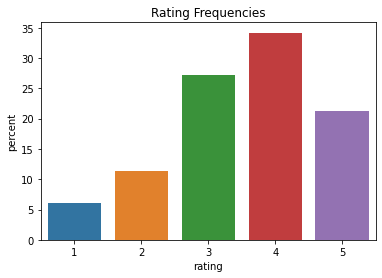

In [ ]:
norm_counts = (
    ratings_df['rating']
    .value_counts(normalize=True, sort=False)
    .multiply(100)
    .reset_index()
    .rename(columns={'rating': 'percent', 'index': 'rating'})
)
ax = sns.barplot(x='rating', y='percent', data=norm_counts)
ax.set_title('Rating Frequencies')
plt.show()

How many ratings were submitted per month?

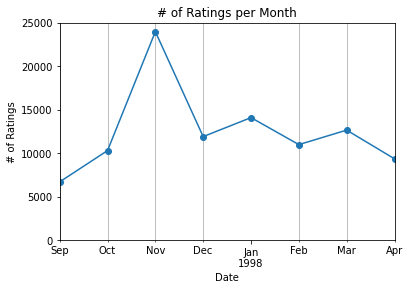

In [ ]:
def _process_ratings(ratings_df):
  ratings_df = ratings_df.copy()
  ratings_df['timestamp'] = ratings_df['timestamp'].apply(datetime.fromtimestamp)
  ratings_df['year'] = ratings_df['timestamp'].dt.year
  ratings_df['month'] = ratings_df['timestamp'].dt.month
  ratings_df = ratings_df.sort_values('timestamp')
  return ratings_df

_ratings_df = _process_ratings(ratings_df)
month_counts = _ratings_df[['year', 'month', 'rating']].groupby(['year', 'month']).count()
month_counts = month_counts.rename(index=str, columns={'rating': '# of Ratings'})
month_counts = month_counts.reset_index()
month_counts['Date'] = month_counts[['year', 'month']].apply(
    lambda x: datetime(year=int(x[0]), month=int(x[1]), day=1), axis=1
)
month_counts = month_counts.set_index('Date', drop=True)
month_counts['# of Ratings'].plot(style='o-')
plt.ylabel('# of Ratings')
plt.title('# of Ratings per Month')
plt.ylim([0, 25000])
plt.gca().grid(which='minor')
plt.show()

How consistent are the average ratings over time?

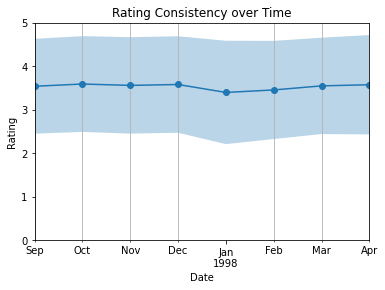

In [ ]:
month_counts = _ratings_df.groupby(['year', 'month'])['rating'].agg([np.mean, np.std])
month_counts = month_counts.rename(index=str, columns={'mean': 'Rating'})
month_counts = month_counts.reset_index()
month_counts['Date'] = month_counts[['year', 'month']].apply(
    lambda x: datetime(year=int(x[0]), month=int(x[1]), day=1), axis=1
)
month_counts = month_counts.set_index('Date', drop=True)
month_counts['Rating'].plot(style='o-')
plt.fill_between(month_counts.index,
                 month_counts['Rating'] - month_counts['std'],
                 month_counts['Rating'] + month_counts['std'],
                 alpha=0.3,
                )
plt.ylim([0, 5])
plt.ylabel('Rating')
plt.gca().grid(which='minor')
plt.title('Rating Consistency over Time')
plt.show()

How quickly do the movie and user bases grow over time?

*(assume that a user has joined on her first rating, and that she remains a user from then on.)*

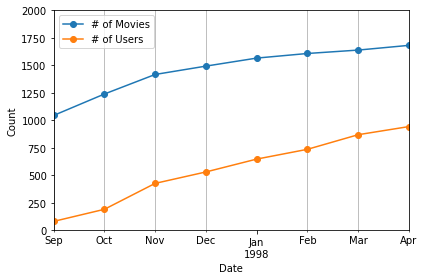

In [ ]:
_ratings_df['Date'] = _ratings_df[['year', 'month']].apply(
    lambda x: datetime(year=int(x[0]), month=int(x[1]), day=1), axis=1
)
n_users = []
n_movies = []
dates = np.unique(_ratings_df['Date'])
for date in dates:
    n_users.append(_ratings_df[_ratings_df['Date'] <= date]['user_id'].nunique())
    n_movies.append(_ratings_df[_ratings_df['Date'] <= date]['item_id'].nunique())
df_users = pd.DataFrame({'Date': dates, '# of Users': n_users}).set_index('Date')
df_movies = pd.DataFrame({'Date': dates, '# of Movies': n_movies}).set_index('Date')
fig, ax = plt.subplots()
df_movies['# of Movies'].plot(style='o-', ax=ax)
df_users['# of Users'].plot(style='o-', ax=ax)
plt.ylabel('Count')
plt.ylim([0, 2000])
ax.grid(which='minor')
plt.tight_layout()
plt.legend()
plt.show()

How sparse is the user/movies matrix we'll be dealing with?

In [ ]:
def get_rating_matrix(X):
    """Function to generate a ratings matrix and mappings for
    the user and item ids to the row and column indices
    Parameters
    ----------
    X : pandas.DataFrame, shape=(n_ratings,>=3)
        First 3 columns must be in order of user, item, rating.
    Returns
    -------
    rating_matrix : 2d numpy array, shape=(n_users, n_items)
    user_map : pandas Series, shape=(n_users,)
        Mapping from the original user id to an integer in the range [0,n_users)
    item_map : pandas Series, shape=(n_items,)
        Mapping from the original item id to an integer in the range [0,n_items)
    """
    user_col, item_col, rating_col = X.columns[:3]
    rating = X[rating_col]
    user_map = pd.Series(
        index=np.unique(X[user_col]),
        data=np.arange(X[user_col].nunique()),
        name='user_map',
    )
    item_map = pd.Series(
        index=np.unique(X[item_col]),
        data=np.arange(X[item_col].nunique()),
        name='columns_map',
    )
    user_inds = X[user_col].map(user_map)
    item_inds = X[item_col].map(item_map)
    rating_matrix = (
        pd.pivot_table(
            data=X,
            values=rating_col,
            index=user_inds,
            columns=item_inds,
        )
        .fillna(0)
        .values
    )
    return rating_matrix, user_map, item_map

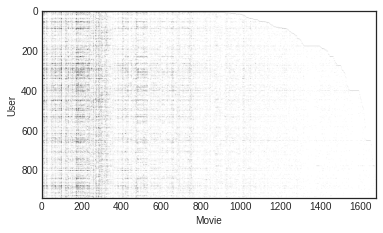

In [ ]:
rating_matrix, user_map, item_map = get_rating_matrix(ratings_df)
with plt.style.context('seaborn-white'):
    rating_matrix_binary = rating_matrix > 0
    plt.imshow(rating_matrix_binary)
    plt.xlabel('Movie')
    plt.ylabel('User')
    plt.show()

In [ ]:
rating_matrix

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [ ]:
Markdown(
    r"The matrix density is $n_{{ratings}}/(n_{{users}} \times n_{{movies}}) = {:0.3f}$"
    .format(np.sum(rating_matrix_binary) / np.prod(rating_matrix.shape))
)

The matrix density is $n_{ratings}/(n_{users} \times n_{movies}) = 0.063$

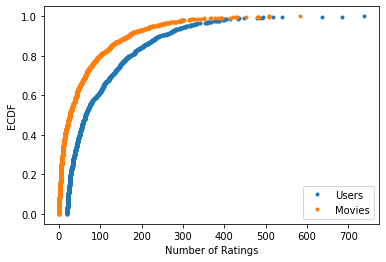

In [ ]:
user_counts = ratings_df['user_id'].value_counts(ascending=True)
user_counts.index = np.arange(len(user_counts)) / len(user_counts)
plt.plot(user_counts, user_counts.index, '.', label='Users')
movie_counts = ratings_df['item_id'].value_counts(ascending=True)
movie_counts.index = np.arange(len(movie_counts)) / len(movie_counts)
plt.plot(movie_counts, movie_counts.index, '.', label='Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('ECDF')
plt.legend()
plt.show()

## Preprocessing

In [ ]:
display(ratings_df.head())

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## Baseline Models

### Baseline - Simple Average Model
The first model we'll test is about the simplest one possible. We'll just average all the training set ratings and use that average for the prediction for all test set examples.

In [ ]:
class SimpleAverageModel():
    """A very simple model that just uses the average of the ratings in the
    training set as the prediction for the test set.

    Attributes
    ----------
    mean : float
        Average of the training set ratings
    """

    def __init__(self):
        pass

    def fit(self, X):
        """Given a ratings dataframe X, compute the mean rating
        
        Parameters
        ----------
        X : pandas dataframe, shape = (n_ratings, >=3)
            User, item, rating dataframe. Only the 3rd column is used.
        
        Returns
        -------
        self
        """
        self.mean = X.iloc[:, 2].mean()
        return self

    def predict(self, X):
        return np.ones(len(X)) * self.mean

### Baseline - Average by ID Model
We can probably do a little better by using the user or item (movie) average. Here we'll set up a baseline model class that allows you to pass either a list of userIds or movieIds as X. The prediction for a given ID will just be the average of ratings from that ID, or the overall average if that ID wasn't seen in the training set.

In [ ]:
class AverageByIdModel():
    """Simple model that predicts based on average ratings for a given Id
    (movieId or userId) from training data
    
    Parameters
    ----------
    id_column : string
        Name of id column (i.e. 'itemId', 'userId') to average by in
        dataframe that will be fitted to

    Attributes
    ----------
    averages_by_id : pandas Series, shape = [n_ids]
        Pandas series of rating averages by id
    overall_average : float
        Average rating over all training samples
    """
    def __init__(self, id_column):
        self.id_column = id_column

    def fit(self, X):
        """Fit training data.

        Parameters
        ----------
        X : pandas dataframe, shape = (n_ratings, >=3)
            User, item, rating dataframe. Columns beyond 3 are ignored

        Returns
        -------
        self : object
        """
        rating_column = X.columns[2]
        X = X[[self.id_column, rating_column]].copy()
        X.columns = ['id', 'rating']
        self.averages_by_id = (
            X
            .groupby('id')['rating']
            .mean()
            .rename('average_rating')
        )
        self.overall_average = X['rating'].mean()
        return self

    def predict(self, X):
        """Return rating predictions

        Parameters
        ----------
        X : pandas dataframe, shape = (n_ratings, >=3)
            Array of n_ratings movieIds or userIds

        Returns
        -------
        y_pred : numpy array, shape = (n_ratings,)
            Array of n_samples rating predictions
        """
        rating_column = X.columns[2]
        X = X[[self.id_column, rating_column]].copy()
        X.columns = ['id', 'rating']
        X = X.join(self.averages_by_id, on='id')
        X['average_rating'].fillna(self.overall_average, inplace=True)
        return X['average_rating'].values

### Baseline - Damped Baseline with User + Movie Data

This baseline model takes into account the average ratings of both the user and the movie, as well as a damping factor that brings the baseline prediction closer to the overall mean. The damping factor has been shown empirically to improve the perfomance.

This model follows equation 2.1 from a [collaborative filtering paper](http://files.grouplens.org/papers/FnT%20CF%20Recsys%20Survey.pdf) from [GroupLens](https://grouplens.org/), the same group that published the MovieLens data. This equation defines rhe baseline rating for user $u$ and item $i$ as 

$$b_{u,i} = \mu + b_u + b_i$$

where

$$b_u = \frac{1}{|I_u| + \beta_u}\sum_{i \in I_u} (r_{u,i} - \mu)$$

and

$$b_i = \frac{1}{|U_i| + \beta_i}\sum_{u \in U_i} (r_{u,i} - b_u - \mu).$$

(See equations 2.4 and 2.5). Here, $\beta_u$ and $\beta_i$ are damping factors, for which the paper reported 25 is a good number for this dataset. For now we'll just leave these values equal ($\beta=\beta_u=\beta_i$). Here's a summary of the meanings of all the variables here:

| Variable        | Meaning                                               |
| --------------- | ----------------------------------------------------- |
| $b_{u,i}$       | Baseline rating for user $u$ on item (movie) $i$      |
| $\mu$           | The mean of all ratings                               |
| $b_u$           | The deviation from $\mu$ associated with user $u$     |
| $b_i$           | The deviation from $\mu+b_u$ associated with user $i$ |
| $I_u$           | The set of all items rated by user $u$                |
| $\mid I_u \mid$ | The number of items rated by user $u$                 |
| $\beta_u$       | Damping factor for the users ($=\beta$)               |
| $r_{u,i}$       | Observed rating for user $u$ on item $i$              |
| $U_i$           | The set of all users who rated item $i$               |
| $\mid U_i \mid$ | The number of users who rated item $i$                |
| $\beta_i$       | Damping factor for the items ($=\beta$)               |

In [ ]:
class DampedUserMovieBaselineModel():
    """Baseline model that of the form mu + b_u + b_i,
    where mu is the overall average, b_u is a damped user
    average rating residual, and b_i is a damped item (movie)
    average rating residual. See eqn 2.1 of
    http://files.grouplens.org/papers/FnT%20CF%20Recsys%20Survey.pdf

    Parameters
    ----------
    damping_factor : float, default=0
        Factor to bring residuals closer to 0. Must be positive.

    Attributes
    ----------
    mu : float
        Average rating over all training samples
    b_u : pandas Series, shape = [n_users]
        User residuals
    b_i : pandas Series, shape = [n_movies]
        Movie residuals
    damping_factor : float, default=0
        Factor to bring residuals closer to 0. Must be >= 0.
    """
    def __init__(self, damping_factor=0):
        self.damping_factor = damping_factor

    def fit(self, X):
        """Fit training data.

        Parameters
        ----------
        X : DataFrame, shape = [n_samples, >=3]
            User, movie, rating dataFrame. Columns beyond 3 are ignored

        Returns
        -------
        self : object
        """
        X = X.iloc[:, :3].copy()
        X.columns = ['user', 'item', 'rating']
        self.mu = np.mean(X['rating'])
        user_counts = X['user'].value_counts()
        movie_counts = X['item'].value_counts()
        b_u = (
            X[['user', 'rating']]
            .groupby('user')['rating']
            .sum()
            .subtract(user_counts * self.mu)
            .divide(user_counts + self.damping_factor)
            .rename('b_u')
        )
        X = X.join(b_u, on='user')
        X['item_residual'] = X['rating'] - X['b_u'] - self.mu
        b_i = (
            X[['item', 'item_residual']]
            .groupby('item')['item_residual']
            .sum()
            .divide(movie_counts + self.damping_factor)
            .rename('b_i')
        )
        self.b_u = b_u
        self.b_i = b_i
        return self

    def predict(self, X):
        """Return rating predictions

        Parameters
        ----------
        X : DataFrame, shape = (n_ratings, 2)
            User, item dataframe

        Returns
        -------
        y_pred : numpy array, shape = (n_ratings,)
            Array of n_samples rating predictions
        """
        X = X.iloc[:, :2].copy()
        X.columns = ['user', 'item']
        X = X.join(self.b_u, on='user').fillna(0)
        X = X.join(self.b_i, on='item').fillna(0)
        return (self.mu + X['b_u'] + X['b_i']).values

In [ ]:
def get_xval_errs_and_res(df, model, n_splits=5, random_state=0, rating_col='rating'):
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    errs, stds = [], []
    residuals = np.zeros(len(df))
    for train_inds, test_inds in kf.split(df):
        train_df, test_df = df.iloc[train_inds], df.iloc[test_inds]
        pred = model.fit(train_df).predict(test_df)
        residuals[test_inds] = pred - test_df[rating_col]
        mae = mean_absolute_error(pred, test_df[rating_col])
        errs.append(mae)
    return errs, residuals

In [ ]:
errs_1, res_1 = get_xval_errs_and_res(ratings_df, SimpleAverageModel())
errs_2, res_2 = get_xval_errs_and_res(ratings_df, AverageByIdModel('item_id'))
errs_3, res_3 = get_xval_errs_and_res(ratings_df, AverageByIdModel('user_id'))
errs_4, res_4 = get_xval_errs_and_res(ratings_df, DampedUserMovieBaselineModel(0))
errs_5, res_5 = get_xval_errs_and_res(ratings_df, DampedUserMovieBaselineModel(10))
errs_6, res_6 = get_xval_errs_and_res(ratings_df, DampedUserMovieBaselineModel(25))
errs_7, res_7 = get_xval_errs_and_res(ratings_df, DampedUserMovieBaselineModel(50))
df_errs = pd.DataFrame(
    OrderedDict(
        (
            ('Average', errs_1),
            ('Item Average', errs_2),
            ('User Average', errs_3),
            ('Combined 0', errs_4),
            ('Combined 10', errs_5),
            ('Combined 25', errs_6),
            ('Combined 50', errs_7),
        )
    )
)
display(df_errs)
df_errs = (
    pd.melt(df_errs, value_vars=df_errs.columns)
    .rename({'variable': 'Baseline Model', 'value': 'MAE'}, axis=1)
)
df_res = pd.DataFrame(
    OrderedDict(
        (
            ('Average', res_1),
            ('Item Average', res_2),
            ('User Average', res_3),
            ('Combined 0', res_4),
            ('Combined 10', res_5),
            ('Combined 25', res_6),
            ('Combined 50', res_7),
        )
    )
)
display(df_res.tail())
df_res = (
    pd.melt(df_res, value_vars=df_res.columns)
    .rename({'variable': 'Baseline Model', 'value': 'Residual'}, axis=1)
)

,Average,Item Average,User Average,Combined 0,Combined 10,Combined 25,Combined 50
0,0.944496,0.820464,0.832909,0.757803,0.758147,0.765638,0.777938
1,0.943006,0.816231,0.834758,0.755370,0.755676,0.763692,0.776640
2,0.942342,0.811768,0.831787,0.755215,0.753132,0.760062,0.772539
3,0.943253,0.812634,0.835116,0.753721,0.753945,0.761041,0.773358
4,0.950450,0.825487,0.840364,0.766959,0.766122,0.772491,0.784196


,Average,Item Average,User Average,Combined 0,Combined 10,Combined 25,Combined 50
99995,0.528338,0.055556,0.416393,-0.059372,-0.018547,0.032939,0.098535
99996,-1.471550,-1.192727,-1.127273,-0.924999,-0.935268,-0.954491,-0.988486
99997,2.528450,1.600000,2.455206,1.609478,1.824161,1.999824,2.147012
99998,1.532850,0.925532,1.114398,0.601937,0.652301,0.715920,0.799292
99999,0.528338,0.872340,1.487805,1.798718,1.595426,1.398599,1.203773


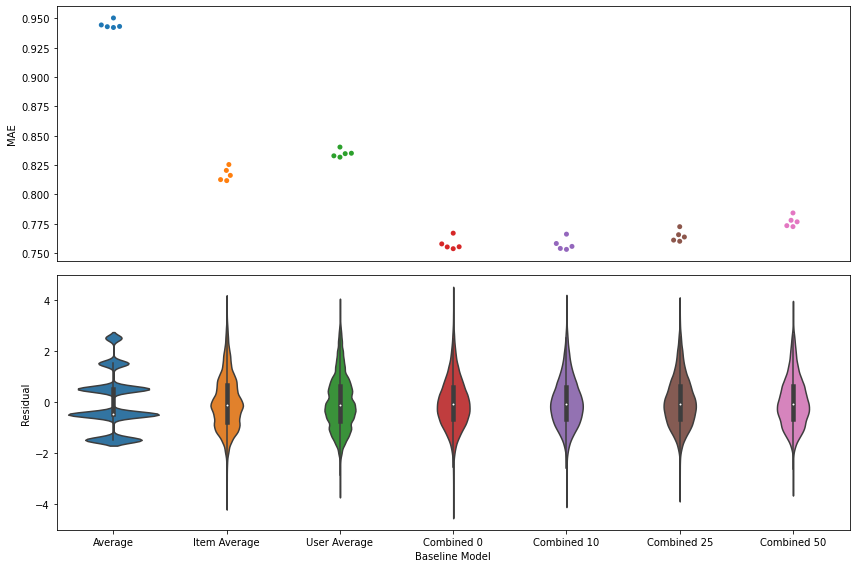

In [ ]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12,8))
sns.swarmplot(data=df_errs, x='Baseline Model', y='MAE', ax=ax0)
sns.violinplot(data=df_res, x='Baseline Model', y='Residual', ax=ax1)
ax0.xaxis.set_visible(False)
plt.tight_layout()
plt.show()

The MAE plots above show that the combined model with a damping factor of 0 or 10 performs the best, followed by the item average, then the user average. It makes sense that taking into account deviations from the mean due to both user and item would perform the best: there is simply more data being taken into account for each baseline prediction. The same idea explains why the item average performs better than the user average: there are more items than users in this dataset, so averaging over items takes into account more data per baseline prediction than averaging over users. The residual plots underneath the MAE plot illustrate that taking into account more data pulls the density of the residuals closer to 0.

**Selecting the baseline**: Both the Combined 0 and Combined 10 models performed equally, but we'll choose the Combined 10 model, because a higher damping factor is effectively stronger regularization, which will prevent overfitting better than a damping factor of 0.

## KNN Collaborative Filtering

In [ ]:
# <!-- collapse=True -->
class KNNRecommender():
    """User-based or Item-based collaborative filtering model that operates on
    dataframes with at least a user-like, item-like, and a rating-like column
    
    Parameters
    ----------
    mode : str, ['item | 'user'], default='item'
        Tells model whether to use item-based or user-based collaborative filtering
    k : int, default=20
        Number of most similar items or users to average for prediction
    basline_algo : object, optional
        Algorithm used to predict baseline scores for each rating. If not provided,
        the mean of all training ratings is used as the baseline. If provided,
        the object must have a fit(X) method and a predict(X) method
    similarity_func : function, default=cosine_similarity
        Function must take a numpy array M of shape (m,n) and return a numpy array
        of shape (m,m) where each element i,j represents the similarity between row
        i and row j of M.
    loop_predict : boolean, default=True
        If True, the model will loop over all user-item pairs in test set and compute
        prediction individually. If False, the model will compute all ratings
        simultaneously. With sparse matrices, looping is typically faster.
        
    Attributes
    ----------
    train_mean : float
        Mean of the training data ratings. Used if baseline_algo is None.
    rating_matrix : 2d numpy array, shape=(n_users, n_items)
        Rating matrix minus baselines
    user_map : pandas Series, shape=(n_users,)
        Mapping from the original user id to an integer in the range [0,n_users)
    item_map : pandas Series, shape=(n_items,)
        Mapping from the original item id to an integer in the range [0,n_items)
    knn_indices : 2d numpy array, shape=([n_users|n_items], k)
        Element i,j represents the index of the jth closet [user|item] to i
    knn_similarities : 2d numpy array, shape=([n_users|n_items], k)
        Element i,j represents the similarity between the jth closest [user|item] to i
    """
    def __init__(self, mode='item', k=20, baseline_algo=None,
                 similarity_func=cosine_similarity, loop_predict=True):
        if not mode in ['user', 'item']:
            raise ValueError("'mode' must be either 'user' or 'item', not '{}'!".format(mode))

        self.mode = mode
        self.k = k
        self.baseline_algo = baseline_algo
        self.similarity_func = similarity_func
        self.loop_predict = loop_predict
        
        self.train_mean = None
        self.rating_matrix = None
        self.user_map = None
        self.item_map = None
        self.knn_indices = None
        self.knn_similarities = None
        
    def _get_rating_matrix(self, X):
        """Private function to generate a ratings matrx and mappings for
        the user and item ids to the row and column indices
        
        Parameters
        ----------
        X : pandas.DataFrame, shape=(n_ratings,>=3)
            First 3 columns must be in order of user, item, rating.
        
        Returns
        -------
        rating_matrix : 2d numpy array, shape=(n_users, n_items)
        user_map : pandas Series, shape=(n_users,)
            Mapping from the original user id to an integer in the range [0,n_users)
        item_map : pandas Series, shape=(n_items,)
            Mapping from the original item id to an integer in the range [0,n_items)
        """
        user_col, item_col, rating_col = X.columns[:3]
        rating = X[rating_col]
        user_map = pd.Series(
            index=np.unique(X[user_col]),
            data=np.arange(X[user_col].nunique()),
            name='user_map',
        )
        item_map = pd.Series(
            index=np.unique(X[item_col]),
            data=np.arange(X[item_col].nunique()),
            name='columns_map',
        )
        user_inds = X[user_col].map(user_map)
        item_inds = X[item_col].map(item_map)
        rating_matrix = (
            pd.pivot_table(
                data=X,
                values=rating_col,
                index=user_inds,
                columns=item_inds,
            )
            .fillna(0)
            .values
        )
        return rating_matrix, user_map, item_map

    def _get_knn_indices_and_similarities(self, rating_matrix):
        """Private function to find indices and similarities of k nearest
        neighbors for each user or item
        
        Parameters
        ----------
        rating_matrix : 2d numpy array, shape=(n_users, n_items)
            Matrix of ratings minus baselines
        
        Returns
        -------
        knn_indices : 2d numpy array, shape=([n_users|n_items], k)
            Element i,j represents the index of the jth closet [user|item] to i
        knn_similarities : 2d numpy array, shape=([n_users|n_items], k)
            Element i,j represents the similarity between the jth closest [user|item] to i
        """
        if self.mode == 'item':
            n_users_or_items = rating_matrix.shape[1]
        else:
            n_users_or_items = rating_matrix.shape[0]
        if self.k > n_users_or_items:
            new_k = n_users_or_items - 1
            print(
                "Warning: k = {} > # {}s = {}! Setting k to {}"
                .format(self.k, n_users_or_items, self.mode, new_k)
            )
            self.k = new_k
        if self.mode == 'item':
            similarity_matrix = self.similarity_func(rating_matrix.T)
        else:
            similarity_matrix = self.similarity_func(rating_matrix)
        np.fill_diagonal(similarity_matrix, -1)
        knn_indices = np.argsort(similarity_matrix, axis=1)[:, ::-1][:, :self.k]
        # https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/neighbors/base.py#L373
        sample_range = np.arange(len(knn_indices))[:, None]
        knn_similarities = similarity_matrix[sample_range, knn_indices]
        return knn_indices, knn_similarities
    
    def fit(self, X):
        """Fit model to training data X. Sets the knn_indices, knn_similarities, 
        rating_matrix, user_map, and item map variables.
        
        Parameters
        ----------
        X : pandas DataFrame, shape=(n_ratings, >=3)
            First 3 columns must correspond to user, item, and rating in that order
        
        Returns
        -------
        self
            This allows chaining like `KNNRecommender().fit(X_train).predict(X_test)`
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a DataFrame")
        X = X.copy()
        user_col, item_col, rating_col = X.columns[:3]
        if self.baseline_algo is None:
            self.train_mean = X[rating_col].mean()
            X['rating_baseline'] = self.train_mean
        else:
            self.baseline_algo.fit(X.iloc[:, :3])
            X['rating_baseline'] = self.baseline_algo.predict(X[[user_col, item_col]])
        X['rating_diff'] = X[rating_col] - X['rating_baseline']
        nodiff_rating_matrix, _, _ = self._get_rating_matrix(X[[user_col, item_col, rating_col]])
        self.knn_indices, self.knn_similarities = self._get_knn_indices_and_similarities(
            nodiff_rating_matrix
        )
        gc.collect()
        self.rating_matrix, self.user_map, self.item_map = self._get_rating_matrix(
            X[[user_col, item_col, 'rating_diff']]
        )
        return self

    def _predict_1_ui_pair(self, user, item):
        """Predict rating (minus baseline) for 1 user-item pair. Must add
        baseline to get the rating in the original rating scale.
        
        Parameters
        ----------
        user : int
            Must be in range [0, n_users)
        item : int
            Must be in range [0, n_items)
        
        Returns
        -------
        rating_pred : float
            Predicted ratings
        """
        if self.mode == 'item':
            inds_i = self.knn_indices[item, :]
            sims_i = self.knn_similarities[item, :]
            # https://stackoverflow.com/a/35696047/2680824
            numerator = np.sum(self.rating_matrix[user, inds_i] * sims_i)
            denominator = np.sum(np.abs(sims_i))
            with np.errstate(divide='ignore', invalid='ignore'):
                rating_pred = numerator / denominator
        else:
            inds_u = self.knn_indices[user, :]
            sims_u = self.knn_similarities[user, :]
            # https://stackoverflow.com/a/35696047/2680824
            numerator = np.sum(self.rating_matrix[inds_u, item] * sims_u)
            denominator = np.sum(np.abs(sims_u))
            with np.errstate(divide='ignore', invalid='ignore'):
                rating_pred = numerator / denominator
        return rating_pred

    def predict(self, X):
        """Predict ratings for each user-item pair in X
        
        Parameters
        ----------
        X : pandas DataFrame, shape=(n_ratings, >=2)
            First 2 columns of X must correspond to user and item.
        
        Returns
        -------
        pandas Series, shape=(n_ratings,)
            Ratings for each user-item pair in X. No restriction on the data type
            for the user and item ids, other than they must match the training indices.
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a DataFrame")
        X = X.copy()
        user_col, item_col = X.columns[:2]
        if self.baseline_algo is None:
            X['rating_baseline'] = self.train_mean
        else:
            X['rating_baseline'] = self.baseline_algo.predict(X)
        X['rating'] = 0
        known_user_and_item_mask = (
            X[user_col].isin(self.user_map.index) & X[item_col].isin(self.item_map.index)
        )
        X_known = X[known_user_and_item_mask]
        user_inds = X_known[user_col].map(self.user_map)
        item_inds = X_known[item_col].map(self.item_map)
        if self.loop_predict:
            rating_pred = np.array([
                self._predict_1_ui_pair(u_ind, i_ind)
                for u_ind, i_ind in zip(user_inds, item_inds)
            ])
        else:
            stacked_ratings = self.rating_matrix[
                self.knn_indices[:, :, None],
                np.arange(self.rating_matrix.shape[1])[None, None, :]
            ]
            numerator_matrix = np.sum(
                stacked_ratings * self.knn_similarities[:, :, None],
                axis=1
            )
            denominator_matrix = np.sum(
                (stacked_ratings != 0) * self.knn_similarities[:, :, None],
                axis=1
            )
            # https://stackoverflow.com/a/35696047/2680824
            with np.errstate(divide='ignore', invalid='ignore'):
                rating_pred_matrix = numerator_matrix / denominator_matrix
            rating_pred = rating_pred_matrix[user_inds, item_inds]
        rating_pred[np.isnan(rating_pred)] = 0
        X.loc[known_user_and_item_mask, 'rating'] = rating_pred
        return X['rating'] + X['rating_baseline']

Determine Optimal  k  Values

In [ ]:
def cart_prod(df_1, df_2):
    df_1['_dummy_'], df_2['_dummy_'] = 1, 1
    return pd.merge(df_1, df_2, on='_dummy_').drop('_dummy_', axis=1)

n_splits = 5

k_list = [1, 2, 5, 10, 20, 50, 100, 200]
mode_list = ['user', 'item']
i_fold_list = np.arange(n_splits)
df_1 = pd.DataFrame({'k': k_list})
df_2 = pd.DataFrame({'mode': mode_list})
df_3 = pd.DataFrame({'i_fold': i_fold_list})
results_df = reduce(cart_prod, [df_1, df_2, df_3])
results_df.head(10)

,k,mode,i_fold
0,1,user,0
1,1,user,1
2,1,user,2
3,1,user,3
4,1,user,4
5,1,item,0
6,1,item,1
7,1,item,2
8,1,item,3
9,1,item,4


In [ ]:
kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)

for (k, mode), group in results_df.groupby(['k', 'mode']):
    for (index, row), (train_inds, test_inds) in zip(group.iterrows(), kf.split(ratings_df)):
        print("k={}, mode={}: i_fold= ".format(row['k'], row['mode']), end='')
        print("{}, ".format(row['i_fold']), end='')
        train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
        baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
        t1 = datetime.now()
        rec = KNNRecommender(mode=row['mode'], k=row['k'], baseline_algo=baseline_algo)
        rec.fit(train_df)
        preds = rec.predict(test_df[['user_id', 'item_id']])
        mae = mean_absolute_error(preds, test_df['rating'])
        results_df.loc[index, 'MAE'] = mae
        dt = (datetime.now() - t1).total_seconds()
        print("{:5.3f}   dt={:.2f} seconds".format(mae, dt))
        results_df.loc[index, 'time'] = dt

k=1, mode=item: i_fold= 0, 0.813   dt=1.12 seconds
k=1, mode=item: i_fold= 1, 0.810   dt=1.07 seconds
k=1, mode=item: i_fold= 2, 0.803   dt=1.04 seconds
k=1, mode=item: i_fold= 3, 0.810   dt=1.08 seconds
k=1, mode=item: i_fold= 4, 0.807   dt=1.08 seconds
k=1, mode=user: i_fold= 0, 0.828   dt=0.92 seconds
k=1, mode=user: i_fold= 1, 0.829   dt=0.94 seconds
k=1, mode=user: i_fold= 2, 0.829   dt=0.93 seconds
k=1, mode=user: i_fold= 3, 0.833   dt=0.94 seconds
k=1, mode=user: i_fold= 4, 0.833   dt=0.94 seconds
k=2, mode=item: i_fold= 0, 0.765   dt=1.06 seconds
k=2, mode=item: i_fold= 1, 0.764   dt=1.08 seconds
k=2, mode=item: i_fold= 2, 0.757   dt=1.06 seconds
k=2, mode=item: i_fold= 3, 0.760   dt=1.09 seconds
k=2, mode=item: i_fold= 4, 0.765   dt=1.07 seconds
k=2, mode=user: i_fold= 0, 0.785   dt=0.93 seconds
k=2, mode=user: i_fold= 1, 0.785   dt=0.93 seconds
k=2, mode=user: i_fold= 2, 0.781   dt=0.98 seconds
k=2, mode=user: i_fold= 3, 0.786   dt=0.94 seconds
k=2, mode=user: i_fold= 4, 0.79

In [ ]:
baseline_df = pd.DataFrame({'i_fold': i_fold_list})

for (index, row), (train_inds, test_inds) in zip(baseline_df.iterrows(), kf.split(ratings_df)):
    print("i_fold={}: MAE=".format(row['i_fold']), end='')
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
    baseline_algo.fit(train_df)
    preds = baseline_algo.predict(test_df[['user_id', 'item_id']])
    mae = mean_absolute_error(preds, test_df['rating'])
    baseline_df.loc[index, 'MAE'] = mae
    print("{:5.3f}".format(mae))

i_fold=0: MAE=0.758
i_fold=1: MAE=0.756
i_fold=2: MAE=0.753
i_fold=3: MAE=0.754
i_fold=4: MAE=0.766


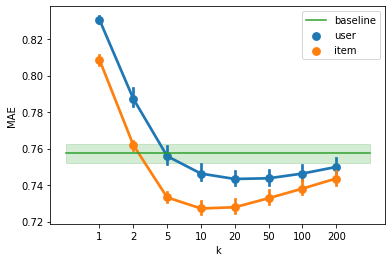

In [ ]:
base_avg = baseline_df['MAE'].mean()
base_std = baseline_df['MAE'].std()
sns.pointplot(data=results_df, x='k', hue='mode', y='MAE')
nk = results_df['k'].nunique()
plt.plot([-1, nk], [base_avg, base_avg], label='baseline', color='C2')
plt.fill_between([-1, nk], [base_avg - base_std]*2, [base_avg+base_std]*2, color='C2', alpha=0.2)
plt.legend()
plt.show()

## ALS & SGD

In [ ]:
class ALSRecommender():
    """Recommender based on Alternating Least Squares algorithm.
    
    Parameters
    ----------
    k : int, default=5
        Number of latent features
    lmbda : float, default=0.1
        Regularization parameter
    max_epochs : int, default=15
        Max number of iterations to run
    baseline_algo : object
        Object with fit(X) and 
    """
    def __init__(self, k=5, lmbda=0.1, max_epochs=15, baseline_algo=None, error_metric='mae',
                 verbose=True):
        # Force integer in case it comes in as float
        self.k = int(np.round(k))
        self.lmbda = lmbda
        self.max_epochs = max_epochs
        self.baseline_algo = baseline_algo
        self.error_metric = error_metric
        self.verbose = verbose

        self.U = None
        self.I = None
        self.initialized = False

    def _calc_train_error(self, U, I, R, R_selector=None, error_metric='mae'):
        if R_selector is None:
            R_selector = (R > 0)
        R_hat = np.dot(U.T, I)
        if error_metric == 'mae':
            error = np.sum(R_selector * np.abs(R_hat - R)) / np.sum(R_selector)
        else:
            raise ValueError("{} is an unsupported error metric".format(metric))
        return error

    def _fit_init(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a DataFrame")
        X = X.copy()
        user_col, item_col, rating_col = X.columns[:3]
        if self.baseline_algo is None:
            self.train_mean = X[rating_col].mean()
        else:
            self.baseline_algo.fit(X)
        self.R, self.user_map, self.item_map = get_rating_matrix(X)
        n_users, n_items = self.R.shape
        self.U = 3 * np.random.rand(self.k, n_users)
        self.I = 3 * np.random.rand(self.k, n_items)
        self.I[0, :] = self.R[self.R != 0].mean(axis=0) # Avg. rating for each movie
        self.E = np.eye(self.k) # (k x k)-dimensional idendity matrix
        self.epoch = 0
        self.train_errors = []
        self.initialized = True

    def fit(self, X, n_epochs=None):
        """Fit model to training data X. If at least one iteration has already been run,
        then the model will continue from its most recent state.
        Parameters
        ----------
        X : pandas DataFrame, shape=(n_ratings, >=3)
            First 3 columns must correspond to user, item, and rating in that order
        n_epochs : int, optional
            Number of iterations to run. If not provided, will run for self.max_epochs
        Returns
        -------
        self
            This allows chaining like `ALSRecommender().fit(X_train).predict(X_test)`
        """
        # Allow continuation from previous state if n_epochs is given. Otherwise start from scratch.
        if n_epochs is None:
            self.initialized = False
        if not self.initialized:
            self._fit_init(X)

        epoch_0 = self.epoch
        if n_epochs is None:
            n_epochs = self.max_epochs - epoch_0

        n_users, n_items = self.R.shape

        # Run n_epochs iterations
        for i_epoch in range(n_epochs):
            if self.epoch >= self.max_epochs:
                print("max_epochs = {}".format(self.max_epochs))
                break
            # Fix I and estimate U
            for i, Ri in enumerate(self.R):
                nui = np.count_nonzero(Ri) # Number of items user i has rated
                if (nui == 0): nui = 1 # Be aware of zero counts!
                # Get array of nonzero indices in row Ii
                Ri_nonzero_selector = np.nonzero(Ri)[0]
                # Select subset of I associated with movies reviewed by user i
                I_Ri = self.I[:, Ri_nonzero_selector]
                # Select subset of row R_i associated with movies reviewed by user i
                Ri_nonzero = self.R[i, Ri_nonzero_selector]
                Ai = np.dot(I_Ri, I_Ri.T) + self.lmbda * nui * self.E
                Vi = np.dot(I_Ri, Ri_nonzero.T)
                self.U[:, i] = np.linalg.solve(Ai, Vi)
            # Fix U and estimate I
            for j, Rj in enumerate(self.R.T):
                nmj = np.count_nonzero(Rj) # Number of users that rated item j
                if (nmj == 0): nmj = 1 # Be aware of zero counts!
                # Get array of nonzero indices in row Ij
                Rj_nonzero_selector = np.nonzero(Rj)[0]
                # Select subset of P associated with users who reviewed movie j
                U_Rj = self.U[:, Rj_nonzero_selector]
                # Select subset of column R_j associated with users who reviewed movie j
                Rj_nonzero = self.R[Rj_nonzero_selector, j]
                Aj = np.dot(U_Rj, U_Rj.T) + self.lmbda * nmj * self.E
                Vj = np.dot(U_Rj, Rj_nonzero)
                self.I[:, j] = np.linalg.solve(Aj, Vj)
            error = self._calc_train_error(self.U, self.I, self.R)
            self.train_errors.append(error)
            if self.verbose:
                print("[Epoch {}/{}] train error: {}".format(self.epoch, self.max_epochs, error))
            self.epoch += 1
        return self

    def predict(self, X):
        """Generate predictions for user/item pairs
        
        Parameters
        ----------
        X : pandas dataframe, shape = (n_pairs, 2)
            User, item dataframe
            
        Returns
        -------
        rating_pred : 1d numpy array, shape = (n_pairs,)
            Array of rating predictions for each user/item pair
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a DataFrame")
        X = X.copy()
        user_col, item_col = X.columns[:2]
        if self.baseline_algo is None:
            X['rating_baseline'] = self.train_mean
        else:
            X['rating_baseline'] = self.baseline_algo.predict(X)
        X['rating'] = 0
        known_user_and_item_mask = (
            X[user_col].isin(self.user_map.index) & X[item_col].isin(self.item_map.index)
        )
        X_known, X_unknown = X[known_user_and_item_mask], X[~known_user_and_item_mask]
        user_inds = X_known[user_col].map(self.user_map)
        item_inds = X_known[item_col].map(self.item_map)
        rating_pred = np.array([
            np.sum(self.U[:, u_ind] * self.I[:, i_ind])
            for u_ind, i_ind in zip(user_inds, item_inds)
        ])
        X.loc[known_user_and_item_mask, 'rating'] = rating_pred
        X.loc[~known_user_and_item_mask, 'rating'] = self.baseline_algo.predict(X_unknown)
        min_rating = np.min(self.R[np.nonzero(self.R)])
        max_rating = np.max(self.R)
        X.loc[X['rating'] < min_rating, 'rating'] = min_rating
        X.loc[X['rating'] > max_rating, 'rating'] = max_rating
        return X['rating'].values


class SGDRecommender():
    """Stochastic Gradient Descent recommender.
    
    Parameters
    ----------
    k : int, default=5
        Number of latent features
    learning_rate : float, default=0.1
        Speed at which to descend down gradient
    max_epochs : int, default=15
        Max number of iterations to run
    error_metric : string, default='mae'
        Error metric to use
    user_reg : float, default=0.0
        Regularization parameter for the latent feature weights in U, >=0
    item_reg : float, default=0.0
        Regularization parameter for the latent feature weights in I, >=0
    user_bias_reg : float, default=0.0
        Regularization parameter for the b_u terms, >=0
    item_bias_reg : float, default=0.0
        Regularization parameter for the b_i terms, >=0
    damping_factor : float, default=25
        Damping factor to be used in the baseline algorithm
    minibatch_size : int, default=1
        Number of user/item pairs to evaluate at a time during training
    verbose : boolean, default=True
        If True, print progress.
    """
    def __init__(self, k=5, learning_rate=0.1, max_epochs=15, error_metric='mae',
                 user_reg=0.0, item_reg=0.0, user_bias_reg=0.0, item_bias_reg=0.0,
                 damping_factor=25, minibatch_size=1, verbose=True):
        self.k = k
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.error_metric = error_metric
        self.user_reg = user_reg
        self.item_reg = item_reg
        self.user_bias_reg = user_bias_reg
        self.item_bias_reg = item_bias_reg
        self.damping_factor = damping_factor
        self.minibatch_size = minibatch_size
        self.verbose = verbose

        self.U = None
        self.I = None
        self.initialized = False

    def _calc_train_error(self, U, I, mu, b_u, b_i, R, R_selector=None):
        if R_selector is None:
            R_selector = (R > 0)
        R_hat = np.dot(U, I.T) + mu + b_u[:, None] + b_i[None, :]
        if self.error_metric == 'mae':
            error = np.sum(R_selector * np.abs(R_hat - R)) / np.sum(R_selector)
        else:
            raise ValueError("{} is an unsupported error metric".format(metric))
        return error

    def _fit_init(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a DataFrame")
        user_col, item_col, rating_col = X.columns[:3]
        self.baseline_algo = DampedUserMovieBaselineModel(damping_factor=self.damping_factor)
        self.baseline_algo.fit(X)
        self.mu = X[rating_col].mean()
        self.b_u, self.b_i = self.baseline_algo.b_u.values, self.baseline_algo.b_i.values
        self.R, self.user_map, self.item_map = get_rating_matrix(X)
        n_users, n_items = self.R.shape
        self.U = np.random.normal(scale=1.0/self.k, size=(n_users, self.k))
        self.I = np.random.normal(scale=1.0/self.k, size=(n_items, self.k))
        self.epoch = 0
        self.train_errors = []
        self.initialized = True

    def fit(self, X, n_epochs=None):
        """Fit model to training data X. If at least one iteration has already been run,
        then the model will continue from its most recent state.
        Parameters
        ----------
        X : pandas DataFrame, shape=(n_ratings, >=3)
            First 3 columns must correspond to user, item, and rating in that order
        n_epochs : int, optional
            Number of iterations to run. If not provided, will run for self.max_epochs
        Returns
        -------
        self
            This allows chaining like `SGDRecommender().fit(X_train).predict(X_test)`
        """
        X = X.copy()
        # Allow continuation from previous state if n_epochs is given. Otherwise start from scratch.
        if n_epochs is None:
            self.initialized = False
        if not self.initialized:
            self._fit_init(X)
        X.iloc[:, 0] = X.iloc[:, 0].map(self.user_map)
        X.iloc[:, 1] = X.iloc[:, 1].map(self.item_map)

        epoch_0 = self.epoch
        if n_epochs is None:
            n_epochs = self.max_epochs - epoch_0

        n_users, n_items = self.R.shape

        # Repeat until convergence
        for i_epoch in range(n_epochs):
            if self.epoch >= self.max_epochs:
                print("max_epochs = {}".format(self.max_epochs))
                break
            # Shuffle X
            X = X.sample(frac=1)
            if self.minibatch_size == 1:
                for row in X.itertuples():
                    index, user, item, rating = row[:4]
                    pred = self.predict_1_train(user, item)
                    err = pred - self.R[user, item]
                    self.b_u[user] -= self.learning_rate * (err + self.user_bias_reg * self.b_u[user])
                    self.b_i[item] -= self.learning_rate * (err + self.item_bias_reg * self.b_i[item])
                    self.U[user, :] -= self.learning_rate * (
                        err * self.I[item, :] + self.user_reg * self.U[user, :]
                    )
                    self.I[item, :] -= self.learning_rate * (
                        err * self.U[user, :] + self.item_reg * self.I[item, :]
                    )
            else:
                raise ValueError("Minibatch size greater than 1 not supported yet.")
            error = self._calc_train_error(self.U, self.I, self.mu, self.b_u, self.b_i, self.R)
            self.train_errors.append(error)
            if self.verbose:
                print("[Epoch {}/{}] train error: {}".format(self.epoch, self.max_epochs, error))
            self.epoch += 1
        return self

    def predict_1_train(self, user, item):
        pred = self.mu + self.b_u[user] + self.b_i[item]
        pred += np.dot(self.U[user, :], self.I[item, :])
        return pred

    def predict(self, X):
        """Generate predictions for user/item pairs
        
        Parameters
        ----------
        X : pandas dataframe, shape = (n_pairs, 2)
            User, item dataframe
            
        Returns
        -------
        rating_pred : 1d numpy array, shape = (n_pairs,)
            Array of rating predictions for each user/item pair
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a DataFrame")
        X = X.copy()
        user_col, item_col = X.columns[:2]
        known_user_and_item_mask = (
            X[user_col].isin(self.user_map.index) & X[item_col].isin(self.item_map.index)
        )
        X_known, X_unknown = X[known_user_and_item_mask], X[~known_user_and_item_mask]
        user_inds = X_known[user_col].map(self.user_map)
        item_inds = X_known[item_col].map(self.item_map)
        rating_pred = np.array([
            self.predict_1_train(u_ind, i_ind)
            for u_ind, i_ind in zip(user_inds, item_inds)
        ])
        X.loc[known_user_and_item_mask, 'rating'] = rating_pred
        X.loc[~known_user_and_item_mask, 'rating'] = self.baseline_algo.predict(X_unknown)
        return X['rating'].values

In [ ]:
n_splits = 3
skf = StratifiedKFold(n_splits=n_splits, random_state=0)
splits = [
    (train_inds, test_inds)
    for train_inds, test_inds in skf.split(ratings_df, ratings_df['user_id'])
]

for i_fold, (train_inds, test_inds) in enumerate(splits):
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    train_movie_counts = train_df.groupby('user_id').item_id.count()
    test_movie_counts = test_df.groupby('user_id').item_id.count()
    print("Fold {}:".format(i_fold))
    train_min, train_max = train_movie_counts.min(), train_movie_counts.max()
    test_min, test_max = test_movie_counts.min(), test_movie_counts.max()
    print("  Train: between {} and {} movies per user".format(train_min, train_max))
    print("  Test:  between {} and {} movies per user".format(test_min, test_max))

Fold 0:
  Train: between 13 and 492 movies per user
  Test:  between 6 and 245 movies per user
Fold 1:
  Train: between 13 and 491 movies per user
  Test:  between 6 and 246 movies per user
Fold 2:
  Train: between 13 and 491 movies per user
  Test:  between 6 and 246 movies per user


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [ ]:
def cart_prod(df_1, df_2):
    df_1['_dummy_'], df_2['_dummy_'] = 1, 1
    return pd.merge(df_1, df_2, on='_dummy_').drop('_dummy_', axis=1)

def prep_results_df(lists_dict):
    df = pd.DataFrame({'_dummy_': [1]})
    for name, list in lists_dict.items():
        df = cart_prod(df, pd.DataFrame({name: list}))
    return df

Evaluation functions

In [ ]:
def dcg(top_k_matrix):
    """Compute discounted cumulative gain (DCG) for each row (user) in matrix.
    This measures how good the k recommendations for each user are, with
    decreasing weight placed on items farther down the list. DCG needs to be
    normalized before comparing between users (see normalized discounted
    cumulative gain, or NDCG).
    Links:
        https://link.springer.com/article/10.1007/s11704-015-4584-1
        https://gist.github.com/bwhite/3726239
        https://opensourceconnections.com/blog/2018/02/26/ndcg-scorer-in-quepid
            #cg-dcg-idcg-and-ndcg
    Parameters
    ----------
    top_k_matrix : 2d numpy array, shape = (n_users, k)
        Each row should have the top k ratings for each user from a rating
        matrix in descending order.
    Returns
    -------
    1d numpy array, shape=(n_users,)
        Array of DCG values for each user
    """
    return np.sum(
        top_k_matrix
        /
        np.log2(np.arange(2, top_k_matrix.shape[1]+2))[None, :],
        axis=1
    )

def ndcg(pred_k_matrix, actual_k_matrix):
    """Calculate normalized discounted cumulative gain (NDCG) for each user
    (each row). This is simply the DCG divided by the maximum possible DCG for
    each user. NDCG ranges from 0 to 1, where 1 means movies were chosen that
    actually received the highest k ratings.
    Parameters
    ----------
    pred_k_matrix : 2d numpy array, shape = (n_users, k)
        A matrix of the *actual* ratings of the k movies chosen by the
        recommender system for each user
    actual_k_matrix : 2d numpy array, shape = (n_users, k)
        A matrix of the *actual* ratings of the k movies from the test set
        which the user gave the highest ratings to.
    Returns
    -------
    ndcg_array : 1d numpy array, shape = (n_users,)
        Array of NDCG values for each user
    """
    max_dcg_array = dcg(actual_k_matrix)
    dcg_array = dcg(pred_k_matrix)
    return dcg_array / max_dcg_array

def ndcg_from_df(df, pred, k):
    """Calculate NDCG for each user in the passed dataframe given predicted
    scores and a number of movies to recommend
    Parameters
    ----------
    df : pandas dataframe, shape = (n_ratings, >=3)
        User, item, rating dataframe. All columns after first 3 are ignored
    pred : 1d array-like, shape = (n_ratings,)
        List/array/series of predicted ratings for each user/item pair in df
    k : int
        Number of movies per user to recommend
        
    Returns
    -------
    user_map : pandas series, shape = (n_users,)
        Index = original user ids, value = mapped integer corresponding to
        position in ndcg_array for that user
    ndcg_array : 1d numpy array, shape = (n_users)
        Array of NDCG scores in range (0, 1]
    """
    df = df.iloc[:, :3].copy()
    df.columns = ['user', 'item', 'rating']
    df['pred'] = pred
    pred_matrix, user_map, item_map = get_rating_matrix(df[['user', 'item', 'pred']])
    n_items = len(item_map)
    inds = pred_matrix.argsort(axis=1)[:, :n_items-1-k:-1]
    del pred_matrix
    gc.collect()
    actual_matrix, _, _ = get_rating_matrix(df[['user', 'item', 'rating']])
    pred_k_matrix = actual_matrix[np.arange(len(actual_matrix))[:, None], inds]
    inds = actual_matrix.argsort(axis=1)[:, :n_items-1-k:-1]
    actual_k_matrix = actual_matrix[np.arange(len(actual_matrix))[:, None], inds]
    ndcg_array = ndcg(pred_k_matrix, actual_k_matrix)
    return user_map, ndcg_array

### Choose the best user-based model

*Let's use cross-validation to examine MAE and NDCG@3 on out-of-sample data and choose the "best" user-based model*

In [ ]:
lists_dict = {
    'i_fold': np.arange(n_splits),
    'k': [1, 2, 5, 10, 20, 50, 100],
}
k_recs = 3
baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
user_results_df = prep_results_df(lists_dict)
cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
for c in cols:
    user_results_df[c] = np.nan
for i_fold, (train_inds, test_inds) in enumerate(splits):
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    user_results_i = user_results_df[user_results_df['i_fold']==i_fold]
    for index, row in user_results_i[['i_fold', 'k']].iterrows():
        t1 = datetime.now()
        model = KNNRecommender(mode='user', k=row['k'], baseline_algo=baseline_algo)
        preds = model.fit(train_df).predict(test_df[['user_id', 'item_id']])
        dt = (datetime.now() - t1).total_seconds()
        test_err = mean_absolute_error(test_df['rating'], preds)
        user_map, ndcg_array = ndcg_from_df(test_df, preds, k=k_recs)
        ndcg_mean, ndcg_std = np.mean(ndcg_array), np.std(ndcg_array)
        print("k={}, i_fold={}: MAE={}, NDCG={}".format(row['k'], row['i_fold'], test_err, ndcg_mean))
        cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
        user_results_df.loc[index, cols] = test_err, ndcg_mean, ndcg_std, dt

k=1, i_fold=0: MAE=0.815118677174853, NDCG=0.8369655023253458
k=2, i_fold=0: MAE=0.781600231166416, NDCG=0.8482273405775766
k=5, i_fold=0: MAE=0.7571264942010565, NDCG=0.8630678403049701
k=10, i_fold=0: MAE=0.7496153263636528, NDCG=0.8659193360477797
k=20, i_fold=0: MAE=0.7469469536576984, NDCG=0.8717836126245141
k=50, i_fold=0: MAE=0.7470360905582336, NDCG=0.8716972263659186
k=100, i_fold=0: MAE=0.7488371816907775, NDCG=0.8695180372946614
k=1, i_fold=1: MAE=0.820690147621912, NDCG=0.8359381527480367
k=2, i_fold=1: MAE=0.784450538355682, NDCG=0.847674607736636
k=5, i_fold=1: MAE=0.7593870993315751, NDCG=0.8606143875242239
k=10, i_fold=1: MAE=0.7526014139035732, NDCG=0.8622149031659992
k=20, i_fold=1: MAE=0.7500167049661343, NDCG=0.8658096963086768
k=50, i_fold=1: MAE=0.7508972003037176, NDCG=0.8662743964516358
k=100, i_fold=1: MAE=0.7528793793802401, NDCG=0.8645012299391964
k=1, i_fold=2: MAE=0.8199492154157525, NDCG=0.8351597108738448
k=2, i_fold=2: MAE=0.7834779688045745, NDCG=0.8506

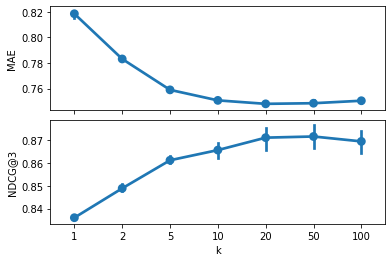

In [ ]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
sns.pointplot(data=user_results_df, x='k', y='test_err', ax=ax0)
ax0.set_ylabel('MAE')
ax0.set_xlabel('')
sns.pointplot(data=user_results_df, x='k', y='ndcg_mean', ax=ax1)
ax1.set_ylabel('NDCG@{}'.format(k_recs))
fig.subplots_adjust(hspace=0.1)
plt.show()

NDCG@3 peaks at $k=50$, and MAE is pretty similar between $k=20$ to $100$, so $k=50$ is the winner.

In [ ]:
baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
best_user_model = KNNRecommender(mode='user', k=50, baseline_algo=baseline_algo)

### Choose the best item-based model
*Let's use cross-validation to examine MAE and NDCG@3 on out-of-sample data and choose the "best" item-based model.*

In [ ]:
lists_dict = {
    'i_fold': np.arange(n_splits),
    'k': [1, 2, 5, 10, 20, 50, 100],
}
k_recs = 3
baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
item_results_df = prep_results_df(lists_dict)
cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
for c in cols:
    item_results_df[c] = np.nan
for i_fold, (train_inds, test_inds) in enumerate(splits):
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    item_results_i = item_results_df[item_results_df['i_fold']==i_fold]
    print("i_fold={}: ".format(i_fold), end='')
    for index, row in item_results_i[['i_fold', 'k']].iterrows():
        t1 = datetime.now()
        model = KNNRecommender(mode='item', k=row['k'], baseline_algo=baseline_algo)
        preds = model.fit(train_df).predict(test_df[['user_id', 'item_id']])
        dt = (datetime.now() - t1).total_seconds()
        test_err = mean_absolute_error(test_df['rating'], preds)
        user_map, ndcg_array = ndcg_from_df(test_df, preds, k=k_recs)
        ndcg_mean, ndcg_std = np.mean(ndcg_array), np.std(ndcg_array)
        print("k={}, ".format(row['k']), end='')
        cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
        item_results_df.loc[index, cols] = test_err, ndcg_mean, ndcg_std, dt
    print()

i_fold=0: k=1, k=2, k=5, k=10, k=20, k=50, k=100, 
i_fold=1: k=1, k=2, k=5, k=10, k=20, k=50, k=100, 
i_fold=2: k=1, k=2, k=5, k=10, k=20, k=50, k=100, 


In [ ]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
sns.pointplot(data=item_results_df, x='k', y='test_err', ax=ax0)
ax0.set_ylabel('MAE')
ax0.set_xlabel('')
sns.pointplot(data=item_results_df, x='k', y='ndcg_mean', ax=ax1)
ax1.set_ylabel('NDCG@{}'.format(k_recs))
fig.subplots_adjust(hspace=0.1)
plt.show()

Here, $k=10$ and $k=20$ have similar MAE and NDCG@3, we'll favor higher $k$ in nearest neigbor methods because higher $k$ is less prone to overfitting. $k=20$ is the winner of the item-based models.

In [ ]:
baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
best_item_model = KNNRecommender(mode='item', k=20, baseline_algo=baseline_algo)

### Choose the best ALS model

Let's use cross-validation to examine MAE and NDCG@3 on out-of-sample data and choose the "best" ALS model.

In [ ]:
max_epochs = 15
lists_dict = {
    'i_fold': np.arange(n_splits),
    'i_epoch': np.arange(max_epochs),
    'k': [5, 10, 50],
}
k_recs = 3
baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
als_epoch_results_df = prep_results_df(lists_dict)
cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
for c in cols:
    als_epoch_results_df[c] = np.nan
for i_fold, (train_inds, test_inds) in enumerate(splits):
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    als_epoch_results_i = als_epoch_results_df[als_epoch_results_df['i_fold']==i_fold]
    for k, group in als_epoch_results_i.groupby('k'):
        model = ALSRecommender(k=k, lmbda=0.1, max_epochs=max_epochs, baseline_algo=baseline_algo,
                             verbose=False)
        print('i_fold={}, k={}: i_epoch='.format(i_fold, k), end='')
        for index, row in group[['i_fold', 'i_epoch']].iterrows():
            t1 = datetime.now()
            preds = model.fit(train_df, n_epochs=1).predict(test_df[['user_id', 'item_id']])
            dt = (datetime.now() - t1).total_seconds()
            test_err = mean_absolute_error(test_df['rating'], preds)
            user_map, ndcg_array = ndcg_from_df(test_df, preds, k=k_recs)
            ndcg_mean, ndcg_std = np.mean(ndcg_array), np.std(ndcg_array)
            print('{}, '.format(row['i_epoch']), end='')
            cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
            als_epoch_results_df.loc[index, cols] = test_err, ndcg_mean, ndcg_std, dt
        print()

i_fold=0, k=5: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=0, k=10: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=0, k=50: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=1, k=5: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=1, k=10: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=1, k=50: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=2, k=5: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=2, k=10: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=2, k=50: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 


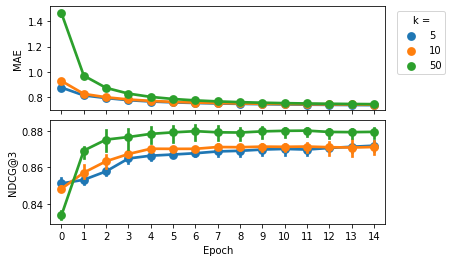

In [ ]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
sns.pointplot(data=als_epoch_results_df, x='i_epoch', y='test_err', hue='k', ax=ax0)
ax0.set_ylabel('MAE')
ax0.set_xlabel('')
ax0.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), title='k =')
sns.pointplot(data=als_epoch_results_df, x='i_epoch', y='ndcg_mean', hue='k', ax=ax1)
ax1.set_ylabel('NDCG@{}'.format(k_recs))
ax1.set_xlabel('Epoch')
ax1.legend_.remove()
fig.subplots_adjust(hspace=0.1)
plt.show()

In [ ]:
max_epochs = 15
lists_dict = {
    'i_fold': np.arange(n_splits),
    'k': [20, 50, 100, 200],
    'lmbda': [0.05, 0.1, 0.2]
}
k_recs = 3
baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
als_results_df = prep_results_df(lists_dict)
cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
for c in cols:
    als_results_df[c] = np.nan
for i_fold, (train_inds, test_inds) in enumerate(splits):
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    als_results_i = als_results_df[als_results_df['i_fold']==i_fold]
    for index, row in als_results_i[['k', 'lmbda']].iterrows():
        model = ALSRecommender(k=row['k'], lmbda=row['lmbda'], max_epochs=max_epochs, baseline_algo=baseline_algo,
                               verbose=False)
        print('i_fold={}, k={}: lmbda={}'.format(i_fold, row['k'], row['lmbda']))
        t1 = datetime.now()
        preds = model.fit(train_df).predict(test_df[['user_id', 'item_id']])
        dt = (datetime.now() - t1).total_seconds()
        test_err = mean_absolute_error(test_df['rating'], preds)
        user_map, ndcg_array = ndcg_from_df(test_df, preds, k=k_recs)
        ndcg_mean, ndcg_std = np.mean(ndcg_array), np.std(ndcg_array)
        cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
        als_results_df.loc[index, cols] = test_err, ndcg_mean, ndcg_std, dt

i_fold=0, k=20.0: lmbda=0.05
i_fold=0, k=20.0: lmbda=0.1
i_fold=0, k=20.0: lmbda=0.2
i_fold=0, k=50.0: lmbda=0.05
i_fold=0, k=50.0: lmbda=0.1
i_fold=0, k=50.0: lmbda=0.2
i_fold=0, k=100.0: lmbda=0.05
i_fold=0, k=100.0: lmbda=0.1
i_fold=0, k=100.0: lmbda=0.2
i_fold=0, k=200.0: lmbda=0.05
i_fold=0, k=200.0: lmbda=0.1
i_fold=0, k=200.0: lmbda=0.2
i_fold=1, k=20.0: lmbda=0.05
i_fold=1, k=20.0: lmbda=0.1
i_fold=1, k=20.0: lmbda=0.2
i_fold=1, k=50.0: lmbda=0.05
i_fold=1, k=50.0: lmbda=0.1
i_fold=1, k=50.0: lmbda=0.2
i_fold=1, k=100.0: lmbda=0.05
i_fold=1, k=100.0: lmbda=0.1
i_fold=1, k=100.0: lmbda=0.2
i_fold=1, k=200.0: lmbda=0.05
i_fold=1, k=200.0: lmbda=0.1
i_fold=1, k=200.0: lmbda=0.2
i_fold=2, k=20.0: lmbda=0.05
i_fold=2, k=20.0: lmbda=0.1
i_fold=2, k=20.0: lmbda=0.2
i_fold=2, k=50.0: lmbda=0.05
i_fold=2, k=50.0: lmbda=0.1
i_fold=2, k=50.0: lmbda=0.2
i_fold=2, k=100.0: lmbda=0.05
i_fold=2, k=100.0: lmbda=0.1
i_fold=2, k=100.0: lmbda=0.2
i_fold=2, k=200.0: lmbda=0.05
i_fold=2, k=200.0: l

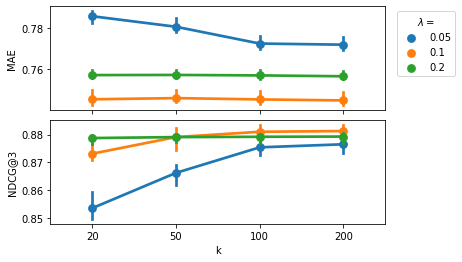

In [ ]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
sns.pointplot(data=als_results_df, x='k', y='test_err', hue='lmbda', ax=ax0)
ax0.set_ylabel('MAE')
ax0.set_xlabel('')
ax0.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), title=r'$\lambda =$')
sns.pointplot(data=als_results_df, x='k', y='ndcg_mean', hue='lmbda', ax=ax1)
ax1.set_ylabel('NDCG@{}'.format(k_recs))
ax1.legend_.remove()
fig.subplots_adjust(hspace=0.1)
plt.show()

Here, it looks like MAE is pretty flat with respect to the learning rate $\lambda$, but NDCG@3 shows some interesting variations. The highest NDCG@3 comes from $\lambda=0.1$ and $k>=50$. With matrix factorization methods like ALS, we want to favor lower $k$ for better generalizability, so $\lambda=0.1$ and $k=50$ is the winner of the ALS category.

In [ ]:
baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
best_als_model = ALSRecommender(k=50, lmbda=0.1, max_epochs=30, baseline_algo=baseline_algo)

### Choose the best SGD model
*Let's use cross-validation to examine MAE and NDCG@3 on out-of-sample data and choose the "best" SGD model.*

In [ ]:
max_epochs = 15
lists_dict = {
    'i_fold': np.arange(n_splits),
    'i_epoch': np.arange(max_epochs),
    'k': [5, 10, 50],
}
k_recs = 3
baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
sgd_epoch_results_df = prep_results_df(lists_dict)
cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
for c in cols:
    sgd_epoch_results_df[c] = np.nan
for i_fold, (train_inds, test_inds) in enumerate(splits):
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    sgd_epoch_results_i = sgd_epoch_results_df[sgd_epoch_results_df['i_fold']==i_fold]
    for k, group in sgd_epoch_results_i.groupby('k'):
        model = SGDRecommender(k=k, learning_rate=0.01, max_epochs=max_epochs, damping_factor=10,
                               verbose=False)
        print('i_fold={}, k={}: i_epoch='.format(i_fold, k), end='')
        for index, row in group[['i_fold', 'i_epoch']].iterrows():
            t1 = datetime.now()
            preds = model.fit(train_df, n_epochs=1).predict(test_df[['user_id', 'item_id']])
            dt = (datetime.now() - t1).total_seconds()
            test_err = mean_absolute_error(test_df['rating'], preds)
            user_map, ndcg_array = ndcg_from_df(test_df, preds, k=k_recs)
            ndcg_mean, ndcg_std = np.mean(ndcg_array), np.std(ndcg_array)
            print('{}, '.format(row['i_epoch']), end='')
            cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
            sgd_epoch_results_df.loc[index, cols] = test_err, ndcg_mean, ndcg_std, dt
        print()

i_fold=0, k=5: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=0, k=10: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=0, k=50: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=1, k=5: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=1, k=10: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=1, k=50: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=2, k=5: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=2, k=10: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=2, k=50: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 


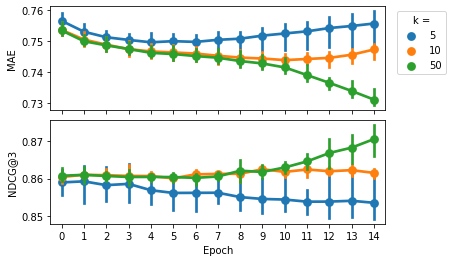

In [ ]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
sns.pointplot(data=sgd_epoch_results_df, x='i_epoch', y='test_err', hue='k', ax=ax0)
ax0.set_ylabel('MAE')
ax0.set_xlabel('')
ax0.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), title='k =')
sns.pointplot(data=sgd_epoch_results_df, x='i_epoch', y='ndcg_mean', hue='k', ax=ax1)
ax1.set_ylabel('NDCG@{}'.format(k_recs))
ax1.set_xlabel('Epoch')
ax1.legend_.remove()
fig.subplots_adjust(hspace=0.1)
plt.show()

In [ ]:
lists_dict = {
    'i_fold': np.arange(n_splits),
    'learning_rate': [0.001, 0.01],
    'reg': [0.0, 0.001, 0.01],
}
k_recs = 3
k = 50
max_epochs = 30
sgd_results_df = prep_results_df(lists_dict)
cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
for c in cols:
    sgd_results_df[c] = np.nan
for i_fold, (train_inds, test_inds) in enumerate(splits):
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    sgd_results_i = sgd_results_df[sgd_results_df['i_fold']==i_fold]
    for index, row in sgd_results_i[['learning_rate', 'reg']].iterrows():
        learning_rate, reg = row['learning_rate'], row['reg']
        model = SGDRecommender(k=k, learning_rate=learning_rate, max_epochs=max_epochs,
                               damping_factor=10, verbose=False,
                               user_reg=reg, item_reg=reg, user_bias_reg=reg, item_bias_reg=reg)
        print('i_fold={}, learning_rate={}, reg={}'.format(i_fold, learning_rate, reg))
        t1 = datetime.now()
        preds = model.fit(train_df).predict(test_df[['user_id', 'item_id']])
        dt = (datetime.now() - t1).total_seconds()
        test_err = mean_absolute_error(test_df['rating'], preds)
        user_map, ndcg_array = ndcg_from_df(test_df, preds, k=k_recs)
        ndcg_mean, ndcg_std = np.mean(ndcg_array), np.std(ndcg_array)
        cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
        sgd_results_df.loc[index, cols] = test_err, ndcg_mean, ndcg_std, dt

i_fold=0, learning_rate=0.001, reg=0.0
i_fold=0, learning_rate=0.001, reg=0.001
i_fold=0, learning_rate=0.001, reg=0.01
i_fold=0, learning_rate=0.01, reg=0.0
i_fold=0, learning_rate=0.01, reg=0.001
i_fold=0, learning_rate=0.01, reg=0.01
i_fold=1, learning_rate=0.001, reg=0.0
i_fold=1, learning_rate=0.001, reg=0.001
i_fold=1, learning_rate=0.001, reg=0.01
i_fold=1, learning_rate=0.01, reg=0.0
i_fold=1, learning_rate=0.01, reg=0.001
i_fold=1, learning_rate=0.01, reg=0.01
i_fold=2, learning_rate=0.001, reg=0.0
i_fold=2, learning_rate=0.001, reg=0.001
i_fold=2, learning_rate=0.001, reg=0.01
i_fold=2, learning_rate=0.01, reg=0.0
i_fold=2, learning_rate=0.01, reg=0.001
i_fold=2, learning_rate=0.01, reg=0.01


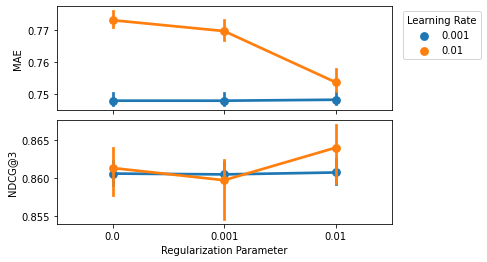

In [ ]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
sns.pointplot(data=sgd_results_df, x='reg', y='test_err', hue='learning_rate', ax=ax0)
ax0.set_ylabel('MAE')
ax0.set_xlabel('')
ax0.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), title='Learning Rate')
sns.pointplot(data=sgd_results_df, x='reg', y='ndcg_mean', hue='learning_rate', ax=ax1)
ax1.set_ylabel('NDCG@{}'.format(k_recs))
ax1.set_xlabel('Regularization Parameter')
ax1.legend_.remove()
fig.subplots_adjust(hspace=0.1)
plt.show()

In [ ]:
reg = 0.01
best_sgd_model = SGDRecommender(k=50, learning_rate=0.01, max_epochs=30, damping_factor=10,
                                user_reg=reg, item_reg=reg, user_bias_reg=reg, item_bias_reg=reg)

### Compare the top methods of each category

In [ ]:
final_models = [best_user_model, best_item_model, best_als_model, best_sgd_model]
final_model_names = ['user', 'item', 'als', 'sgd']
final_results = pd.DataFrame(columns=['model', 'i_fold', 'test_err', 'ndcg_mean', 'ndcg_std', 'dt'])
for model, name in zip(final_models, final_model_names):
    for i_fold, (train_inds, test_inds) in enumerate(splits):
        print("i_fold={}, model={}".format(i_fold, name))
        train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
        if name in ['als', 'sgd']:
            model.verbose = False
        t1 = datetime.now()
        preds = model.fit(train_df).predict(test_df[['user_id', 'item_id']])
        dt = (datetime.now() - t1).total_seconds()
        test_err = mean_absolute_error(test_df['rating'], preds)
        user_map, ndcg_array = ndcg_from_df(test_df, preds, k=3)
        ndcg_mean, ndcg_std = np.mean(ndcg_array), np.std(ndcg_array)
        final_results.loc[len(final_results), :] = name, i_fold, test_err, ndcg_mean, ndcg_std, dt

i_fold=0, model=user
i_fold=1, model=user
i_fold=2, model=user
i_fold=0, model=item
i_fold=1, model=item
i_fold=2, model=item
i_fold=0, model=als
i_fold=1, model=als
i_fold=2, model=als
i_fold=0, model=sgd
i_fold=1, model=sgd
i_fold=2, model=sgd


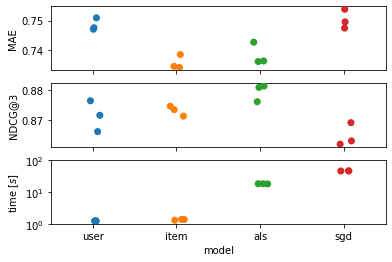

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True)
sns.stripplot(data=final_results, x='model', y='test_err', ax=ax0, jitter=True)
sns.stripplot(data=final_results, x='model', y='ndcg_mean', ax=ax1, jitter=True)
sns.stripplot(data=final_results, x='model', y='dt', ax=ax2, jitter=True)
ax0.set_ylabel('MAE')
ax0.set_xlabel('')
ax1.set_ylabel('NDCG@3')
ax1.set_xlabel('')
ax2.set_ylabel(r'time [$s$]')
ax2.set(yscale='log')
ax2.set_yticks([1, 10, 100])
plt.setp(ax0.collections, sizes=[50])
plt.setp(ax1.collections, sizes=[50])
plt.setp(ax2.collections, sizes=[50])
plt.show()

### Fetching posters

In [ ]:
n_splits = 3
skf = StratifiedKFold(n_splits=n_splits, random_state=0)
splits = [
    (train_inds, test_inds)
    for train_inds, test_inds in skf.split(ratings_df, ratings_df['user_id'])
]

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [ ]:
baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
reg = 0.0
models_dict = {
    'user': KNNRecommender(mode='user', k=50, baseline_algo=baseline_algo),
    'item': KNNRecommender(mode='item', k=20, baseline_algo=baseline_algo),
    'als': ALSRecommender(k=50, lmbda=0.1, max_epochs=15, baseline_algo=baseline_algo, verbose=False),
    'sgd': SGDRecommender(k=50, learning_rate=0.01, max_epochs=30, damping_factor=10,
                          user_reg=reg, item_reg=reg, user_bias_reg=reg, item_bias_reg=reg,
                          verbose=False)
}

In [ ]:
def get_poster_url(movieId, base_url, links_df, api_key):
    movieId = str(int(movieId))
    # Get IMDB movie ID
    tmdbId = links_df.loc[movieId, 'tmdbId']
    
    # Query themoviedb.org API for movie poster path.
    movie_url = 'http://api.themoviedb.org/3/movie/{:}/images'.format(tmdbId)
    headers = {'Accept': 'application/json'}
    payload = {'api_key': api_key} 
    response = requests.get(movie_url, params=payload, headers=headers)
    file_path = json.loads(response.text)['posters'][0]['file_path']
        
    return base_url + file_path

def display_posters(movieIds, base_url, links_df, api_key):
    poster_urls = [get_poster_url(movieId, base_url, links_df, api_key) for movieId in movieIds]
    TABLE = "<table style='width: 100%; align: center;'><tr>{}</tr></table>"
    CELL = "<td align='center'><img style='float: left; width: 120px' src={}></td>"
    table = TABLE.format(''.join([CELL.format(url) for url in poster_urls]))
    display(HTML(table))

def recommend(model, train_df, user, pretrained=False, k=3):
    train_df = train_df.iloc[:, :3].copy()
    train_df.columns = ['user', 'item', 'rating']
    if not pretrained:
        model.fit(train_df)
    seen_movies = train_df[train_df['user'] == user]['item'].unique()
    unseen_movies = list(set(train_df['item'].unique()) - set(seen_movies))
    user_movie_df = pd.DataFrame({'user': [user]*len(unseen_movies), 'item': unseen_movies})
    user_movie_df = user_movie_df[['user', 'item']]
    user_movie_df['pred'] = model.predict(user_movie_df)
    user_movie_df = user_movie_df.sort_values('pred', ascending=False)
    movies, preds = user_movie_df[['item', 'pred']].values[:k, :].T
    return movies, preds

Movies this user likes

In [ ]:
user = 10
train_inds, test_inds = splits[0]
train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
favorite_movies = (
    train_df[train_df['user_id']==user]
    .sort_values('rating', ascending=False)
    .iloc[:5, 1]
    .values
)
display_posters(favorite_movies, base_url, links_df, api_key)

,,,,


Recommended movies

In [ ]:
model = models_dict['als']
movies, preds = recommend(model, train_df, user, pretrained=True, k=5)
display_posters(movies, base_url, links_df, api_key)

,,,,


## Non-Negative Matrix Factorization (NMF, scikit-learn package)

Find two non-negative matrices (W, H) whose product approximates the non-negative matrix R.
NOTE: since the values of matrix R MUST be all positive, we CAN'T do mean-centering normalization here (although this would improve the accuracy).

In [ ]:
from sklearn.decomposition import NMF

nmf_model = NMF(n_components=20)     # starts with 20 latents factors

# Matrix factorization               # V ~ W.H  (Find two non-negative matrices (W, H) whose product approximates the non- negative matrix X. )
nmf_model.fit(rating_matrix)                     # R can be array-like or sparse, here it is array-like (dense)
Theta = nmf_model.transform(rating_matrix)       # user latent factors (= W, called the features matrix)
M = nmf_model.components_.T          # item latent factors (= H.T) (H is called the coefficient matrix)

# Making the predictions
R_pred = M.dot(Theta.T)              # See http://stackoverflow.com/questions/24739121/nonnegative-matrix-factorization-in-sklearn
R_pred = R_pred.T                    # same dimensions as R

print('Item features - M:', M.shape)
print('User features - Theta:', Theta.shape)
print()
print('R ~ M * Theta.T:')
print(R_pred.round(2))
print(R_pred.shape)

Item features - M: (1682, 20)
User features - Theta: (943, 20)

R ~ M * Theta.T:
[[4.5  2.06 1.41 ... 0.   0.02 0.03]
 [2.34 0.03 0.17 ... 0.02 0.   0.  ]
 [0.19 0.02 0.1  ... 0.01 0.   0.  ]
 ...
 [1.98 0.05 0.3  ... 0.   0.   0.  ]
 [1.39 0.1  0.03 ... 0.01 0.01 0.  ]
 [1.6  2.24 1.38 ... 0.   0.03 0.02]]
(943, 1682)


Estimating the error (RMSE) before tuning the hyperparameters

In [ ]:
from sklearn.metrics import mean_squared_error

def get_rmse(pred, actual):
    pred = pred[actual.nonzero()].flatten()     # Ignore nonzero terms
    actual = actual[actual.nonzero()].flatten() # Ignore nonzero terms
    return np.sqrt(mean_squared_error(pred, actual))

get_rmse(R_pred, rating_matrix)

2.2271459436219065

When the predictive model is satisfying, save it to a file

In [ ]:
import pickle

with open('nnmf_sklearn.pickle', 'wb') as f:
  pickle.dump(nmf_model, f)

Item recommendation for an active user (given its rating history)

In [ ]:
def make_recommendation_activeuser(R, prediction, user_idx, k=5):
  '''
  user_idx ...... select an active user
  k  ............ number of movies to recommend
  '''
  rated_items_df_user = pd.DataFrame(R).iloc[user_idx, :]                 # get the list of actual ratings of user_idx (seen movies)
  user_prediction_df_user = pd.DataFrame(prediction).iloc[user_idx,:]     # get the list of predicted ratings of user_idx (unseen movies)
  reco_df = pd.concat([rated_items_df_user, user_prediction_df_user, item_info], axis=1)   # merge both lists with the movie's title
  reco_df.columns = ['rating','prediction','title']

  print('Preferred movies for user #', user_idx)
  print(reco_df.sort_values(by='rating', ascending=False)[:k])             # returns the 5 seen movies with the best actual ratings
  print('Recommended movies for user #', user_idx)
  reco_df = reco_df[ reco_df['rating'] == 0 ]
  print(reco_df.sort_values(by='prediction', ascending=False)[:k])      # returns the 5 unseen movies with the best predicted ratings
  print()
  print()

make_recommendation_activeuser(rating_matrix, R_pred, user_idx=50, k=5)
make_recommendation_activeuser(rating_matrix, R_pred, user_idx=130, k=5)

Preferred movies for user # 50
     rating  prediction title
171     5.0    1.432029   NaN
180     5.0    2.277069   NaN
172     5.0    1.017789   NaN
49      5.0    2.753084   NaN
143     5.0    0.695904   NaN
Recommended movies for user # 50
     rating  prediction title
55      0.0    1.527510   NaN
173     0.0    1.494889   NaN
256     0.0    1.303158   NaN
97      0.0    1.295984   NaN
11      0.0    1.275150   NaN


Preferred movies for user # 130
     rating  prediction title
285     5.0    4.312692   NaN
312     5.0    1.897457   NaN
535     5.0    0.144333   NaN
99      5.0    4.945202   NaN
13      5.0    3.207845   NaN
Recommended movies for user # 130
     rating  prediction title
474     0.0    2.188917   NaN
12      0.0    2.137406   NaN
115     0.0    2.114974   NaN
282     0.0    2.080887   NaN
236     0.0    1.831747   NaN




Item recommendation for a new user (wih rating history)

In [ ]:
# creating a new user profile:
my_ratings = np.zeros((1682,1), dtype=int)
my_ratings[0] = 4 
my_ratings[1] = 4 
my_ratings[10] = 1 
my_ratings[15] = 3
my_ratings[27] = 4
my_ratings[34] = 1
my_ratings[49] = 1
my_ratings[55] = 1
my_ratings[61] = 1
my_ratings[68] = 5
my_ratings[70] = 4
my_ratings[81] = 4
my_ratings[87] = 2
my_ratings[94] = 4
my_ratings[120] = 2
my_ratings[171] = 1
my_ratings[173] = 4
my_ratings[175] = 1
my_ratings[182] = 1
my_ratings[194] = 2
my_ratings[203] = 5
my_ratings[209] = 5
my_ratings[221] = 1
my_ratings[234] = 2
my_ratings[312] = 3
my_ratings[317] = 3
my_ratings[322] = 3
my_ratings[342] = 1
my_ratings[378] = 1
my_ratings[379] = 1
my_ratings[392] = 3
my_ratings[404] = 2
my_ratings[422] = 4
my_ratings[542] = 4

for i in range(len(my_ratings)):
  print(i, my_ratings[i], item_info.iloc[i]['title'])

In [ ]:
# Adding a new user to the R matrix 
newR = np.concatenate((rating_matrix, my_ratings.T))

# Recompute the Matrix factorization
newTheta = estimator.fit_transform(newR)  
newX = estimator.components_.T       

# Making the predictions
newR_pred = newX.dot(newTheta.T).T

# clipping values                                                    
newR_pred[newR_pred > R.max()] = R.max()           # clips ratings above 5             
newR_pred[newR_pred < R.min() + 1] = R.min() +1    # clips ratings below 1

# Making the recommendation
make_recommendation_activeuser(newR, newR_pred, user_idx=newR.shape[0]-1, k=10)

Item recommendation for a new user (wihout rating history)

In [ ]:
def make_recommendation_newuser(item_sim, item_idx, k=5):
  '''
  item_idx ...... select an item
  k  ............ number of movies to recommend
  '''
  reco_item_df = pd.DataFrame(item_sim).iloc[item_idx, :] 
  reco_item_df = pd.concat([reco_item_df, item_info], axis=1)   # merge list with the movie's title
  reco_item_df.columns = ['similarity','title']
  reco_item_df = reco_item_df.sort_values(by='similarity',ascending=False)

  print('Recommended movies for a new user (without rating history), currently looking at movie:', reco_item_df.iloc[0]['title'])
  print(reco_item_df[1:k+1])          # returns the 5 movies the most similar to item_idx
  print()

from sklearn.metrics.pairwise import cosine_similarity
item_sim = cosine_similarity(M)                      # Use item features matrix to compute movie-to-movie similarity matrices
make_recommendation_newuser(item_sim, item_idx=1, k=5)
make_recommendation_newuser(item_sim, item_idx=20, k=5)
make_recommendation_newuser(item_sim, item_idx=500, k=5)

## Hybrid (using processed dataset)
1. Run Content based filtering and determine the movies which we want to recommend to the user.
2. Filter and sort the recommendations of CF using SVD predicted ratings.

Setup

In [ ]:
!git clone https://github.com/vivdalal/movie-recommender-system.git

from math import sqrt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Reading ratings file
hratings = pd.read_csv('movie-recommender-system/ratings.csv', sep=',', encoding='latin-1', usecols=['userId','movieId','rating','timestamp'])
display(ratings.head())

# Reading movies file
hmovies = pd.read_csv('movie-recommender-system/movies.csv', sep=',', encoding='latin-1', usecols=['movieId','title','genres'])
display(movies.head())

fatal: destination path 'movie-recommender-system' already exists and is not an empty directory.


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Content-based model

In [ ]:
tfihmovies_genres = TfidfVectorizer(token_pattern = '[a-zA-Z0-9\-]+')
hmovies['genres'] = hmovies['genres'].replace(to_replace="(no genres listed)", value="")
tfihmovies_genres_matrix = tfihmovies_genres.fit_transform(hmovies['genres'])
cosine_sim_movies = linear_kernel(tfihmovies_genres_matrix, tfihmovies_genres_matrix)

def get_recommendations_based_on_genres(movie_title, cosine_sim_movies=cosine_sim_movies):
    """
    Calculates top 2 movies to recommend based on given movie titles genres. 
    :param movie_title: title of movie to be taken for base of recommendation
    :param cosine_sim_movies: cosine similarity between movies 
    :return: Titles of movies recommended to user
    """
    # Get the index of the movie that matches the title
    idx_movie = hmovies.loc[hmovies['title'].isin([movie_title])]
    idx_movie = idx_movie.index
    
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores_movies = list(enumerate(cosine_sim_movies[idx_movie][0]))
    
    # Sort the movies based on the similarity scores
    sim_scores_movies = sorted(sim_scores_movies, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores_movies = sim_scores_movies[1:3]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores_movies]
    
    # Return the top 2 most similar movies
    return hmovies['title'].iloc[movie_indices]

def get_recommendation_content_model(userId):
    """
    Calculates top movies to be recommended to user based on movie user has watched.  
    :param userId: userid of user
    :return: Titles of movies recommended to user
    """
    recommended_movie_list = []
    movie_list = []
    df_rating_filtered = hratings[hratings["userId"]== userId]
    for key, row in df_rating_filtered.iterrows():
        movie_list.append((hmovies["title"][row["movieId"]==hmovies["movieId"]]).values) 
    for index, movie in enumerate(movie_list):
        for key, movie_recommended in get_recommendations_based_on_genres(movie[0]).iteritems():
            recommended_movie_list.append(movie_recommended)

    # removing already watched movie from recommended list    
    for movie_title in recommended_movie_list:
        if movie_title in movie_list:
            recommended_movie_list.remove(movie_title)
    
    return set(recommended_movie_list)

list(get_recommendation_content_model(1))[:10]

['Scrooged (1988)',
 'Beat the Devil (1953)',
 'Wiz, The (1978)',
 'Mars Attacks! (1996)',
 'Medallion, The (2003)',
 'Ratatouille (2007)',
 'Clueless (1995)',
 'RoboCop 2 (1990)',
 'Stargate (1994)',
 'National Treasure (2004)']

SVD Collaborative model

In [ ]:
# !pip install -q surprise

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

reader = Reader()
data = Dataset.load_from_df(ratings_df[['user_id', 'item_id', 'rating']], reader)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

trainset = data.build_full_trainset()
svd.fit(trainset)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9328  0.9330  0.9455  0.9341  0.9322  0.9355  0.0050  
MAE (testset)     0.7339  0.7376  0.7440  0.7374  0.7330  0.7372  0.0039  
Fit time          5.14    5.14    5.24    5.28    5.26    5.21    0.06    
Test time         0.16    0.27    0.16    0.27    0.16    0.20    0.05    


Hybrid model

In [ ]:
def hybrid_content_svd_model(userId):
    recommended_movies_by_content_model = get_recommendation_content_model(userId)
    recommended_movies_by_content_model = hmovies[hmovies.apply(lambda movie: movie["title"] in recommended_movies_by_content_model, axis=1)]
    for key, columns in recommended_movies_by_content_model.iterrows():
        predict = svd.predict(userId, columns["movieId"])
        recommended_movies_by_content_model.loc[key, "svd_rating"] = predict.est
#         if(predict.est < 2):
#             recommended_movies_by_content_model = recommended_movies_by_content_model.drop([key])
    return recommended_movies_by_content_model.sort_values("svd_rating", ascending=False).iloc[0:11]
        
user_id = 50
hybrid_content_svd_model(user_id)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,movieId,title,genres,svd_rating
275,316,Stargate (1994),Action|Adventure|Sci-Fi,4.316628
777,1019,"20,000 Leagues Under the Sea (1954)",Adventure|Drama|Sci-Fi,4.171654
549,653,Dragonheart (1996),Action|Adventure|Fantasy,4.146008
29,30,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,Crime|Drama,4.143668
71,79,"Juror, The (1996)",Drama|Thriller,4.143321
416,478,Jimmy Hollywood (1994),Comedy|Crime|Drama,4.117090
53,60,"Indian in the Cupboard, The (1995)",Adventure|Children|Fantasy,4.101336
378,434,Cliffhanger (1993),Action|Adventure|Thriller,4.097507
578,709,Oliver & Company (1988),Adventure|Animation|Children|Comedy|Musical,4.091108
10,11,"American President, The (1995)",Comedy|Drama|Romance,4.068649


## LightFM - BPR & WARP

In [ ]:
# !pip install -q lightfm

import numpy as np
from lightfm.datasets import fetch_movielens
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

movielens = fetch_movielens()

for key, value in movielens.items():
    print(key, type(value), value.shape)

train <class 'scipy.sparse.coo.coo_matrix'> (943, 1682)
test <class 'scipy.sparse.coo.coo_matrix'> (943, 1682)
item_features <class 'scipy.sparse.csr.csr_matrix'> (1682, 1682)
item_feature_labels <class 'numpy.ndarray'> (1682,)
item_labels <class 'numpy.ndarray'> (1682,)


In [ ]:
lfm_train = movielens['train']
lfm_test = movielens['test']

In [ ]:
model = LightFM(learning_rate=0.05, loss='bpr')
model.fit(lfm_train, epochs=10)

train_precision = precision_at_k(model, lfm_train, k=10).mean()
test_precision = precision_at_k(model, lfm_test, k=10, train_interactions=lfm_train).mean()

train_auc = auc_score(model, lfm_train).mean()
test_auc = auc_score(model, lfm_test, train_interactions=lfm_train).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.59, test 0.20.
AUC: train 0.90, test 0.88.


BPR optimises for ROC. The WARP model, on the other hand, optimises for precision@k---we should expect its performance to be better on precision.

In [ ]:
model = LightFM(learning_rate=0.05, loss='warp')
model.fit_partial(lfm_train, epochs=10)

train_precision = precision_at_k(model, lfm_train, k=10).mean()
test_precision = precision_at_k(model, lfm_test, k=10, train_interactions=lfm_train).mean()

train_auc = auc_score(model, lfm_train).mean()
test_auc = auc_score(model, lfm_test, train_interactions=lfm_train).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.60, test 0.22.
AUC: train 0.94, test 0.93.


## Microsoft Library - FastAI-Collab

In [ ]:
%cd /content/4CED0278/4CED0278

/content/4CED0278/4CED0278


In [ ]:
import os
import sys
import time
import itertools
import numpy as np
import pandas as pd

import torch, fastai
from fastai.collab import EmbeddingDotBias, collab_learner, CollabDataBunch, load_learner

from reco_utils.dataset.python_splitters import python_stratified_split
from reco_utils.recommender.fastai.fastai_utils import cartesian_product, score
from reco_utils.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from reco_utils.evaluation.python_evaluation import rmse, mae, rsquared, exp_var

In [ ]:
USER, ITEM, RATING, TIMESTAMP, PREDICTION, TITLE = 'UserId', 'MovieId', 'Rating', 'Timestamp', 'Prediction', 'Title'

# top k items to recommend
TOP_K = 10

# select movieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '100k'

# model parameters
N_FACTORS = 40
EPOCHS = 5

ratings = pd.read_csv('./data/ml-100k/ratings.csv')

In [ ]:
ratings.head()

,UserId,MovieId,Rating,Timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


In [ ]:
# split the dataset
train_valid_df, test_df = python_stratified_split(ratings, 
                                                  ratio=0.75, 
                                                  min_rating=5, 
                                                  filter_by="item", 
                                                  col_user=USER, 
                                                  col_item=ITEM )

In [ ]:
data = CollabDataBunch.from_df(train_valid_df, 
                               user_name=USER, 
                               item_name=ITEM, 
                               rating_name=RATING, 
                               valid_pct=0)
data.show_batch()

UserId,MovieId,target
13,588,4.0
279,163,5.0
184,44,4.0
250,28,4.0
514,70,5.0


Now we will create a `collab_learner` for the data, which by default uses 
the `EmbeddingDotBias` model. We will be using 40 latent factors. This will 
create an embedding for the users and the items that will map each of these 
to 40 floats as can be seen below. Note that the embedding parameters are not 
predefined, but are learned by the model.

Although ratings can only range from 1-5, we are setting the range of possible 
ratings to a range from 0 to 5.5 -- that will allow the model to predict values 
around 1 and 5, which improves accuracy. Lastly, we set a value for weight-decay 
for regularization.

In [ ]:
learn = collab_learner(data, n_factors=N_FACTORS, y_range=[0,5.5], wd=1e-1)
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1350, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1350, 1)
)

Now train the model for 5 epochs setting the maximal learning rate. The learner will reduce the learning rate with each epoch using cosine annealing

In [ ]:
learn.fit_one_cycle(EPOCHS, max_lr=5e-3)

epoch,train_loss,valid_loss,time
0,0.955865,#na#,00:10
1,0.867613,#na#,00:10
2,0.784646,#na#,00:10
3,0.619921,#na#,00:10
4,0.543300,#na#,00:10


In [ ]:
# save the learner
learn.export('movielens_model.pkl')

Evaluation

In [ ]:
# load the learner
learner = load_learner(path=".", file='movielens_model.pkl')

# get all users and items that the model knows
total_users, total_items = learner.data.train_ds.x.classes.values()
total_items = total_items[1:]
total_users = total_users[1:]

# get all users from the test set and remove any users that were now in the training set
test_users = test_df[USER].unique()
test_users = np.intersect1d(test_users, total_users)

# build the cartesian product of test set users and all items known to the model
users_items = cartesian_product(np.array(test_users),np.array(total_items))
users_items = pd.DataFrame(users_items, columns=[USER,ITEM])

# remove the user/items combinations that are in the training set
# we don't want to propose a movie that the user has already watched
training_removed = pd.merge(users_items, train_valid_df.astype(str), on=[USER, ITEM], how='left')
training_removed = training_removed[training_removed[RATING].isna()][[USER, ITEM]]

In [ ]:
# score the model to find the top K recommendation
top_k_scores = score(learner, 
                     test_df=training_removed,
                     user_col=USER, 
                     item_col=ITEM, 
                     prediction_col=PREDICTION)

# MAP
eval_map = map_at_k(test_df, top_k_scores, col_user=USER, col_item=ITEM, 
                    col_rating=RATING, col_prediction=PREDICTION, 
                    relevancy_method="top_k", k=TOP_K)

# NDCG
eval_ndcg = ndcg_at_k(test_df, top_k_scores, col_user=USER, col_item=ITEM, 
                      col_rating=RATING, col_prediction=PREDICTION, 
                      relevancy_method="top_k", k=TOP_K)

# Precision
eval_precision = precision_at_k(test_df, top_k_scores, col_user=USER, col_item=ITEM, 
                                col_rating=RATING, col_prediction=PREDICTION, 
                                relevancy_method="top_k", k=TOP_K)

# Recall
eval_recall = recall_at_k(test_df, top_k_scores, col_user=USER, col_item=ITEM, 
                          col_rating=RATING, col_prediction=PREDICTION, 
                          relevancy_method="top_k", k=TOP_K)

print("Model:\t" + learn.__class__.__name__,
      "Top K:\t%d" % TOP_K,
      "MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

In [ ]:
# calculate scores for test user-item pairs
scores = score(learner, 
               test_df=test_df.copy(), 
               user_col=USER, 
               item_col=ITEM, 
               prediction_col=PREDICTION)

# calculate some regression metrics
eval_r2 = rsquared(test_df, scores, col_user=USER, col_item=ITEM, col_rating=RATING, col_prediction=PREDICTION)
eval_rmse = rmse(test_df, scores, col_user=USER, col_item=ITEM, col_rating=RATING, col_prediction=PREDICTION)
eval_mae = mae(test_df, scores, col_user=USER, col_item=ITEM, col_rating=RATING, col_prediction=PREDICTION)
eval_exp_var = exp_var(test_df, scores, col_user=USER, col_item=ITEM, col_rating=RATING, col_prediction=PREDICTION)

print("Model:\t" + learn.__class__.__name__,
      "RMSE:\t%f" % eval_rmse,
      "MAE:\t%f" % eval_mae,
      "Explained variance:\t%f" % eval_exp_var,
      "R squared:\t%f" % eval_r2, sep='\n')